In [4]:
### Script to integrate and align all available data sources with MOFA strategy:
# Single Cell RNA Seq
# Cytokine Data
# Neutrophil Data
# Proteomics

#############################################
# Prerequisites - Load Libraries

In [5]:
source('MS0_Libraries.r')

In [6]:
source('MS4_Plot_Config.r')

###############################################
# Preqrequisites Configurations & Parameters

In [7]:
data_path = '../data/current'

In [8]:
result_path = '../results/current'

In [9]:
data_path

[1] "../data/current"

In [10]:
name = 'V_AZIMUTH_INTEGRATED'  # name of dataset to load

# Functions

In [11]:
### Function for quantile normalization

quantile_normalization = function(X){
  set.seed(42)
  ranks = apply(X, 2, rank, ties.method = 'min')  # determine ranks of each entry
  
  sorted = data.frame(apply(X, 2, sort)) # sort the entries
  means = apply(sorted, 1, mean) # calculate the means
  
  normalized_data = apply(ranks, 2 ,function(x){ means[x]}) # substitute the means into ranks matrix
}


In [12]:
### Gene wise quantile normalization

stdnorm <- function(x) {
  set.seed(42)
  r = rank(x[!is.na(x)], ties.method="average")
  x[!is.na(x)] = qnorm(r / (length(x[!is.na(x)]) + 1))
  return(x)
}

# Load Data 

## Prepared combined data

In [14]:
path = paste0(result_path, '/G-Analysis/Combined_Data_',name,'.csv')
data_long = read.csv(path)
print(file.info(path)$mtime)

[1] "2023-02-01 11:48:06 CET"


In [17]:
data_long$X = NULL

In [18]:
data_distribution = data_long %>% group_by(variable, type) %>% summarise(mean_val = mean(value, na.rm = TRUE), var_val = var(value, na.rm = TRUE))

`summarise()` has grouped output by 'variable'. You can override using the
`.groups` argument.


In [19]:
max(data_distribution$mean_val)

[1] 0.07254292

In [20]:
min(data_distribution$mean_val) - max(data_distribution$mean_val)

[1] -0.1397985

In [21]:
min(data_distribution$var_val)

[1] 0

In [22]:
#data_distribution = data_distribution[data_distribution$var_val != 0,]

In [23]:
min(data_distribution$var_val)

[1] 0

In [24]:
min(data_distribution$var_val) - max(data_distribution$var_val)

[1] -0.9428643

In [25]:
head(data_distribution,2)

variable,type,mean_val,var_val
<chr>,<chr>,<dbl>,<dbl>
A1BG_M0R009,proteomics,7.541697e-18,0.9403528
A1BG_P04217.2,proteomics,7.532927e-18,0.9403528


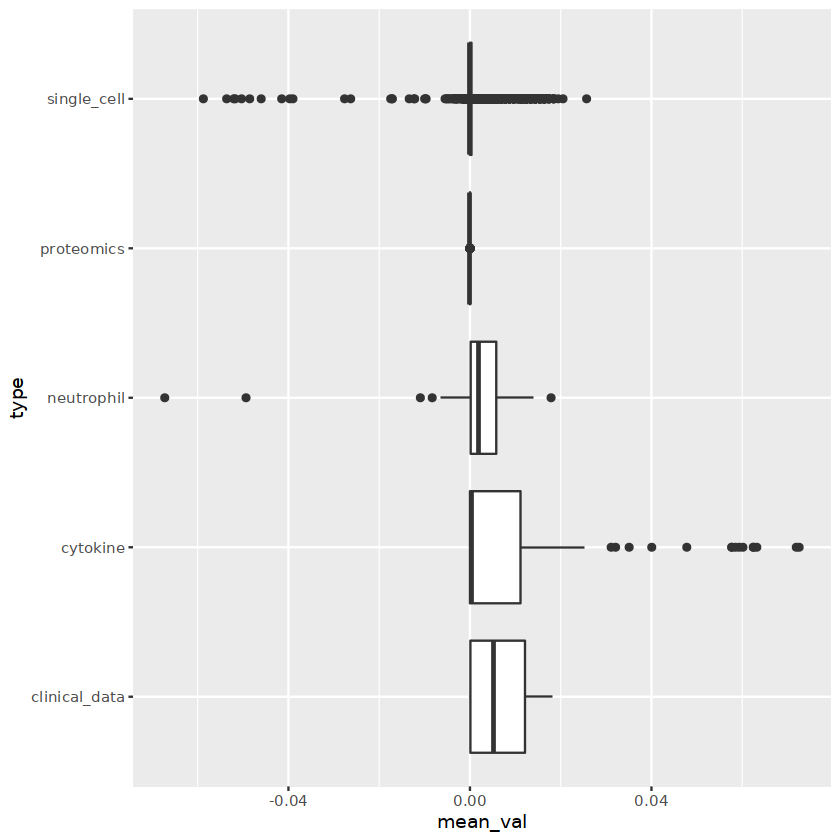

In [26]:
ggplot(data_distribution, aes(x=mean_val, y=type)) + 
    geom_boxplot()

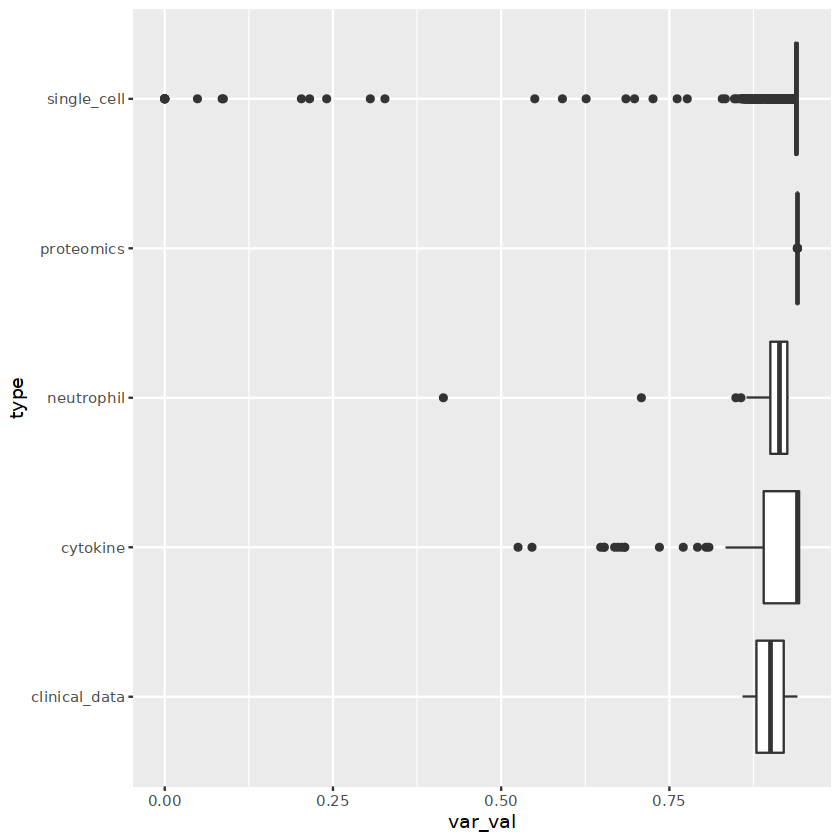

In [27]:
ggplot(data_distribution, aes(x=var_val, y=type)) + 
    geom_boxplot()

## Sample Data

In [30]:
sample_data = read.csv(paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv'))

In [32]:
sample_data$CK_raw = sample_data$CK

In [33]:
sample_data$CK = log2(sample_data$CK+1)

In [34]:
sample_data$Troponin = log2(sample_data$Troponin+1)

In [35]:
sample_data$CK_MB = log2(as.numeric(sample_data$CK_MB)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [36]:
sample_data$CRP =  log2(as.numeric(sample_data$CRP)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [37]:
sample_data$sample_id[(sample_data$sample_id == 'm13.2')  & (sample_data$library %in%  c('L6'))] = 'm13.22'

In [38]:
sample_data$sample_id[(sample_data$sample_id == 'm6.4')  & (sample_data$library %in%  c('L10'))] = 'm6.42'

In [39]:
sample_data$sample_id[(sample_data$sample_id == 'm6.1')  & (sample_data$library %in%  c('L3'))] = 'm6.12'

## Nichenet data (for specifying ligands)

In [60]:
ligand_target_matrix = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))  # gene-gene regulatory scores
# gives the regulatory potential of a target gene based on the ligand-tf & tf- target-gene links and weights of the signaling and gr network (multiply PPR of each ligand -tf  pair with the weights of the gr network)

In [61]:
### Generate data in long format

In [62]:
ligand_target_matrix_long = melt(ligand_target_matrix)

In [63]:
colnames(ligand_target_matrix_long) = c('target', 'ligand', 'regulatory_potential')

In [64]:
head(ligand_target_matrix_long,2)

,target,ligand,regulatory_potential
,<fct>,<fct>,<dbl>
1,A1BG,CXCL1,0.0003534343
2,A1BG-AS1,CXCL1,0.0001650894


In [65]:
ligands = unique(ligand_target_matrix_long$ligand)

In [66]:
head(ligands)

[1] CXCL1 CXCL2 CXCL3 CXCL5 PPBP  CXCL6
688 Levels: CXCL1 CXCL2 CXCL3 CXCL5 PPBP CXCL6 CXCL8 CXCL9 CXCL10 ... PCDHA12

# Train MOFA Model

In [67]:
length(unique(data_long$variable))

[1] 9145

## Prepare data list

In [68]:
length(unique(data_long$sample_id))

[1] 128

In [69]:
final_data_long_backup = data_long

In [70]:
final_data_long = final_data_long_backup

In [71]:
final_data_long$cell_type = NULL

In [72]:
final_data_long$variable_transformed = NULL

In [73]:
final_data_long$type[ final_data_long$type == 'single_cell'] = str_extract(final_data_long$variable[ final_data_long$type == 'single_cell'] , '.*__')

In [74]:
final_data_long$config = NULL

In [75]:
final_data_long$X = NULL

In [80]:
### Filter only samples measured across multiple TPs

In [81]:
samples = unique(final_data_long$sample_id)

In [82]:
unique(final_data_long$type)

[1] "clinical_data" "cytokine"      "neutrophil"    "proteomics"   
 [5] "B.cell__"      "CD14.Mono__"   "CD16.Mono__"   "CD4.CTL__"    
 [9] "CD4.Naive__"   "CD4.TCM__"     "CD4.TEM__"     "CD8.Naive__"  
[13] "CD8.TEM__"     "cDC2__"        "gdT__"         "NK__"         
[17] "Treg__"

In [83]:
length(samples)

[1] 128

In [84]:
### Prepare data list for MOFA

In [85]:
data_list = list()

In [86]:
head(final_data_long,2)

,sample_id,variable,value,type
,<chr>,<chr>,<dbl>,<chr>
1,k1,CK,-2.397022,clinical_data
2,k10,CK,NA,clinical_data


In [87]:
#final_data_long$variable = str_extract(final_data_long$variable, '__.*')

In [88]:
#final_data_long$variable = str_replace(final_data_long$variable, '__', '')

In [89]:
nrow(final_data_long)

[1] 1170560

In [90]:
### Optional: decide whether clinical data should be involved

In [93]:
nrow(final_data_long)

[1] 1170560

In [96]:
head(final_data_long,2)

,sample_id,variable,value,type
,<chr>,<chr>,<dbl>,<chr>
1,k1,CK,-2.397022,clinical_data
2,k10,CK,NA,clinical_data


In [99]:
data_list= list()

In [100]:
for(i in unique(final_data_long$type)){
    data = final_data_long[final_data_long$type == i, ]
    
    data$type = NULL
    data$cell_type = NULL
    
    data = data %>% dcast(variable ~ sample_id, value  = "value")
    rownames(data) = data$variable
    colnames(data) = str_replace(colnames(data), 'value\\.', '')
    data$variable = NULL
    
    data[setdiff( samples, names(data))] = NA  # use all samples
    
    data = data[,order(colnames(data))]
    data = data[,colnames(data) %in% samples]
    
    data_list[[i]] = as.matrix(data)
    }

In [101]:
dim(data)

[1] 356 128

In [103]:
head(data_list[[1]],2)

,k1,k10,k11,k12,k13,k14,k15,k16,k17,k18,⋯,m7.2,m7.3,m7.4,m8.1,m8.2,m8.3,m8.4,m9.1,m9.2,m9.3
CK,-2.397022,NA,-1.443924,-0.8775918,-1.505361,-0.3268231,-0.6941258,-1.648873,-1.335178,-0.9402147,⋯,1.2402687,0.4383163,-0.6941258,-0.5921965,-0.9897138,-1.078094,NA,0.8775918,1.0417650,0.05181301
CK_MB,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,0.9766002,-0.5602008,NA,NA,NA,NA,NA,0.5204647,0.6853063,-0.50090447


## Create MOFA object

### Create for own data and train

In [104]:
names(data_list) = str_replace_all(names(data_list) , '__|\\.|\\.\\.|\\.\\.\\.', '')

In [105]:
data_list_orig = data_list

In [106]:
## Adjustments for plotting overview

In [107]:
names(data_list) = str_replace(names(data_list), 'X0_TcellCD4', 'CD4+ T cells (Cluster 0)')
names(data_list) = str_replace(names(data_list), 'clinical_data', 'Clinical')
names(data_list) = str_replace(names(data_list), 'X1_TcellCD8', 'CD8+ T cells (Cluster 1)')
names(data_list) = str_replace(names(data_list), 'X10_Bcell', 'B cells (Cluster 10)')
names(data_list) = str_replace(names(data_list), 'X11_TcellCD4', 'CD4+ T cells (Cluster 11)')
names(data_list) = str_replace(names(data_list), 'X12_MonocytesCD16_FCGR3A', 'FCGR3A(high) Monocytes (Cluster 12)')
names(data_list) = str_replace(names(data_list), 'X13_Dendritic', 'Dendritic cells (Cluster 13)')
names(data_list) = str_replace(names(data_list), 'X2_TcellCD4', 'CD4+ T cells (Cluster 2)')
names(data_list) = str_replace(names(data_list), 'X3_NK', 'NK cells (Cluster 3)')
names(data_list) = str_replace(names(data_list), 'X4_MonocytesCD14', 'CD14(high) Monocytes (Cluster 4)')
names(data_list) = str_replace(names(data_list), 'X5_TcellCD4', 'CD4+ T cells (Cluster 5)')
names(data_list) = str_replace(names(data_list), 'X6_MonocytesCD14', 'CD14(high) Monocytes (Cluster 6)')
names(data_list) = str_replace(names(data_list), 'X7_MonocytesCD14', 'CD14(high) Monocytes (Cluster 7)')
names(data_list) = str_replace(names(data_list), 'X8_Bcell','B cells (Cluster 8)')
names(data_list) = str_replace(names(data_list), 'X9_MonocytesCD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')


names(data_list) = str_replace(names(data_list), 'clinical','Clinical')
names(data_list) = str_replace(names(data_list), 'cytokine','Cytokine')
names(data_list) = str_replace(names(data_list), 'neutrophil','Neutrophil')
names(data_list) = str_replace(names(data_list), 'proteomics','Proteomics')

In [108]:
names(data_list)

[1] "Clinical"   "Cytokine"   "Neutrophil" "Proteomics" "Bcell"     
 [6] "CD14Mono"   "CD16Mono"   "CD4CTL"     "CD4Naive"   "CD4TCM"    
[11] "CD4TEM"     "CD8Naive"   "CD8TEM"     "cDC2"       "gdT"       
[16] "NK"         "Treg"

In [109]:
head(data_list[[1]])

,k1,k10,k11,k12,k13,k14,k15,k16,k17,k18,⋯,m7.2,m7.3,m7.4,m8.1,m8.2,m8.3,m8.4,m9.1,m9.2,m9.3
CK,-2.3970221,NA,-1.443924,-0.8775918,-1.5053606,-0.3268231,-0.6941258,-1.648873,-1.335178,-0.9402147,⋯,1.2402687,0.4383163,-0.6941258,-0.5921965,-0.9897138,-1.078094,NA,0.8775918,1.0417650,0.05181301
CK_MB,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,0.9766002,-0.5602008,NA,NA,NA,NA,NA,0.5204647,0.6853063,-0.50090447
CRP,-0.3186394,-0.8871466,-1.574445,NA,-0.3186394,0.2683089,-1.5744450,NA,-1.574445,NA,⋯,NA,0.9051525,0.3827258,0.7050659,1.2760918,1.663793,1.426077,-0.5024022,NA,0.38272581
Troponin,-1.2864792,NA,-1.286479,-1.2864792,-1.2864792,-0.8172368,-1.2864792,-1.286479,-1.286479,-1.2864792,⋯,0.6744898,0.4585578,NA,-0.6211776,-0.5951785,NA,NA,-0.5194481,0.6211776,0.21779838


In [110]:
#str(data_list)

In [111]:
MOFAobject = create_mofa(data_list)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




In [112]:
### Plot Data Overview

In [113]:
options(repr.plot.width=30, repr.plot.height=10)
mofa_overview = plot_data_overview(MOFAobject)

In [114]:
length(unique(data_long$variable))

[1] 9145

In [115]:
# Specific Text Descriptions:
xlabel = xlab('Samples') 
ylabel = ylab('View')

In [116]:
# Sizes of the plot
width_par = 8.07
height_par =6

In [117]:
mofa_overview = mofa_overview + plot_config +
                xlabel + ylabel + theme(axis.text.x = element_blank())

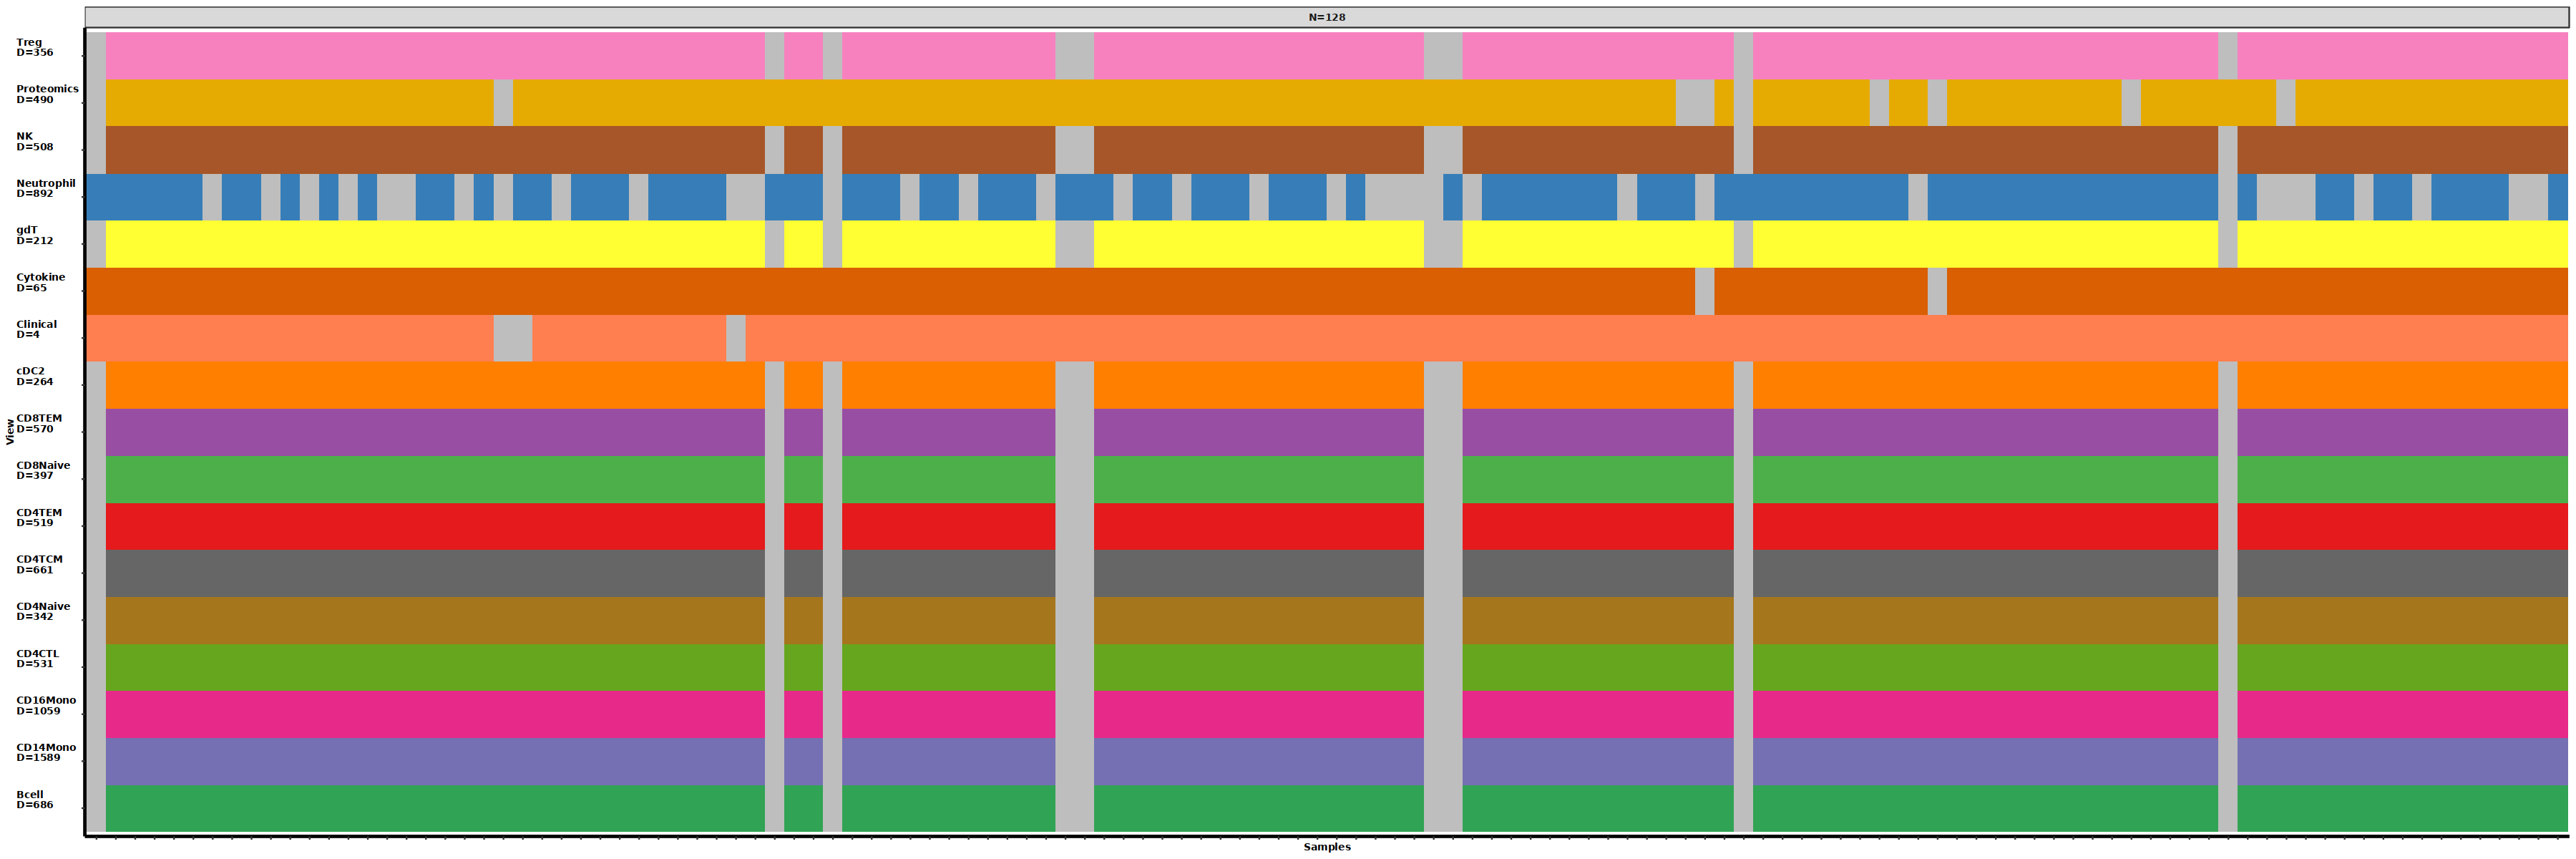

In [118]:
mofa_overview

In [119]:
### Use orig MOFA object

In [120]:
MOFAobject = create_mofa(data_list_orig)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




###  Add covariates for mefisto

In [121]:
MOFAobject

Untrained MOFA model with the following characteristics: 
 Number of views: 17 
 Views names: clinical_data cytokine neutrophil proteomics Bcell CD14Mono CD16Mono CD4CTL CD4Naive CD4TCM CD4TEM CD8Naive CD8TEM cDC2 gdT NK Treg 
 Number of features (per view): 4 65 892 490 686 1589 1059 531 342 661 519 397 570 264 212 508 356 
 Number of groups: 1 
 Groups names: group1 
 Number of samples (per group): 128 
 

In [122]:
#cov = as.data.frame(cov)

### Set data options

In [123]:
mefisto_opts = get_default_mefisto_options(MOFAobject)

In [124]:
data_opts = get_default_data_options(MOFAobject)

In [125]:
data_opts

$scale_views
[1] FALSE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] FALSE

$views
 [1] "clinical_data" "cytokine"      "neutrophil"    "proteomics"   
 [5] "Bcell"         "CD14Mono"      "CD16Mono"      "CD4CTL"       
 [9] "CD4Naive"      "CD4TCM"        "CD4TEM"        "CD8Naive"     
[13] "CD8TEM"        "cDC2"          "gdT"           "NK"           
[17] "Treg"         

$groups
[1] "group1"

In [126]:
data_opts$scale_views = TRUE # decide whether to scale the data

In [127]:
## Define model options

In [128]:
model_opts = get_default_model_options(MOFAobject)
model_opts

$likelihoods
clinical_data      cytokine    neutrophil    proteomics         Bcell 
   "gaussian"    "gaussian"    "gaussian"    "gaussian"    "gaussian" 
     CD14Mono      CD16Mono        CD4CTL      CD4Naive        CD4TCM 
   "gaussian"    "gaussian"    "gaussian"    "gaussian"    "gaussian" 
       CD4TEM      CD8Naive        CD8TEM          cDC2           gdT 
   "gaussian"    "gaussian"    "gaussian"    "gaussian"    "gaussian" 
           NK          Treg 
   "gaussian"    "gaussian" 

$num_factors
[1] 15

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] TRUE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE

In [129]:
model_opts$num_factors = 20 # define number of factors

In [130]:
#model_opts$likelihoods

### Define training options

In [131]:
train_opts  = get_default_training_options(MOFAobject)
train_opts

$maxiter
[1] 1000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] -1

$verbose
[1] FALSE

$startELBO
[1] 1

$freqELBO
[1] 5

$stochastic
[1] FALSE

$gpu_mode
[1] FALSE

$seed
[1] 42

$outfile
NULL

$weight_views
[1] FALSE

$save_interrupted
[1] FALSE

In [132]:
train_opts$maxiter = 50000

In [133]:
train_opts$verbose = TRUE

In [134]:
train_opts$seed = 42

In [135]:
train_opts$weight_views = FALSE

### Stochastic Options

In [136]:
stoch_options = get_default_stochastic_options(MOFAobject)

In [137]:
stoch_options

$batch_size
[1] 0.5

$learning_rate
[1] 1

$forgetting_rate
[1] 0.5

$start_stochastic
[1] 1

### Build and train the model

In [138]:
MOFAobject = prepare_mofa(
  object = MOFAobject,
  data_options = data_opts,
  model_options = model_opts,
  mefisto_options = mefisto_opts,
  training_options = train_opts #,
  #stochastic_options = stoch_options
)

Warning message in prepare_mofa(object = MOFAobject, data_options = data_opts, model_options = model_opts, :
“Some view(s) have less than 15 features, MOFA will have little power to to learn meaningful factors for these view(s)....”
Checking data options...

Checking training options...

Checking model options...



### Save the model

In [140]:
train_opts$weight_views

[1] FALSE

In [141]:
model_name = paste0("MOFA_MODEL", name, '-', train_opts$weight_views,'.hdf5')

In [142]:
model_name

#  old: 'MOFA_Model_26_02V20_Duplicates-FALSE-TRUE-TRUE.hdf5'

[1] "MOFA_MODELV_AZIMUTH_INTEGRATED-FALSE.hdf5"

In [143]:
outfile = file.path( paste0(result_path, '/G-Analysis/',  model_name) )

In [144]:
outfile

[1] "../results/current/G-Analysis/MOFA_MODELV_AZIMUTH_INTEGRATED-FALSE.hdf5"

In [145]:
#outfile

In [146]:
MOFAobject.trained = run_mofa(MOFAobject, outfile, use_basilisk = FALSE)


Connecting to the mofapy2 python package using reticulate (use_basilisk = FALSE)... 
    Please make sure to manually specify the right python binary when loading R with reticulate::use_python(..., force=TRUE) or the right conda environment with reticulate::use_condaenv(..., force=TRUE)
    If you prefer to let us automatically install a conda environment with 'mofapy2' installed using the 'basilisk' package, please use the argument 'use_basilisk = TRUE'


Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 5, 10, 11, 17 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


In [147]:
nrow(sample_data)

[1] 149

In [148]:
length(unique(sample_data$sample_id))

[1] 149

In [149]:
model <- load_model(outfile, verbose = TRUE)

Loading data...

Loading expectations for 2 nodes...

Loading model options...

Loading training options and statistics...

Assigning names to the different dimensions...

Re-ordering factors by their variance explained...

Doing quality control...

Checking views names...

Checking groups names...

Checking samples names...

Checking features names...

Checking dimensions...

Checking there are no features with complete missing values...

Checking sample covariates...

Checking expectations...

Checking for intercept factors...

Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 5, 10, 11, 17 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”
Checking for highly correlated factors...



In [150]:
length(unique(data_long$variable))

[1] 9145

In [151]:
head(data_long)

,sample_id,variable,value,type
,<chr>,<chr>,<dbl>,<chr>
1,k1,CK,-2.3970221,clinical_data
2,k10,CK,NA,clinical_data
3,k11,CK,-1.4439241,clinical_data
4,k12,CK,-0.8775918,clinical_data
5,k13,CK,-1.5053606,clinical_data
6,k14,CK,-0.3268231,clinical_data


# Downstream Analysis of generated model

In [152]:
#str(model)

In [153]:
#model = MOFAobject.trained

In [154]:
model@dimensions$D

clinical_data      cytokine    neutrophil    proteomics         Bcell 
            4            65           892           490           686 
     CD14Mono      CD16Mono        CD4CTL      CD4Naive        CD4TCM 
         1589          1059           531           342           661 
       CD4TEM      CD8Naive        CD8TEM          cDC2           gdT 
          519           397           570           264           212 
           NK          Treg 
          508           356

In [155]:
sum(model@dimensions$D)

[1] 9145

## Add metadata to model

In [156]:
head(model@samples_metadata, n=3)

,group,sample
,<fct>,<chr>
1,group1,k1
2,group1,k10
3,group1,k11


In [159]:
#ample_data

In [160]:
nrow(sample_data)

[1] 149

In [161]:
length(unique(sample_data$sample_id))

[1] 149

In [162]:
#head( sample_data)

In [163]:
model@samples_metadata = merge(model@samples_metadata, sample_data, by.x = 'sample', by.y = 'sample_id')

In [165]:
nrow(model@samples_metadata)

[1] 128

## Investigate Variance decomposition

In [170]:
# Total variance explained per view and group

In [171]:
model@cache[["variance_explained"]]$r2_total

$group1
clinical_data      cytokine    neutrophil    proteomics         Bcell 
     58.78266      22.32225      18.59081      13.92705      36.88700 
     CD14Mono      CD16Mono        CD4CTL      CD4Naive        CD4TCM 
     59.50922      35.78651      38.41822      30.60948      60.35611 
       CD4TEM      CD8Naive        CD8TEM          cDC2           gdT 
     36.38315      20.83869      39.38670      28.17896      49.56972 
           NK          Treg 
     41.34954      31.68343

In [172]:
rowMeans(model@cache$variance_explained$r2_per_factor[[1]])

Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7   Factor8 
5.4912709 5.1363422 3.1257362 2.8809232 2.4359567 2.2153391 1.5319879 1.4439659 
  Factor9  Factor10  Factor11  Factor12  Factor13  Factor14  Factor15  Factor16 
1.4295145 1.3944897 1.3631298 1.2911348 1.2362905 1.2252778 1.1631951 1.0475653 
 Factor17  Factor18  Factor19  Factor20 
0.7872397 0.7753696 0.7651823 0.6747375

In [174]:
mean(model@cache$variance_explained$r2_total[[1]])

[1] 36.62232

In [175]:
mean(colSums(model@cache$variance_explained$r2_per_factor[[1]]))

[1] 37.41465

In [176]:
str(model@cache$variance_explained)

List of 2
 $ r2_total     :List of 1
  ..$ group1: num [1:17(1d)] 58.8 22.3 18.6 13.9 36.9 ...
  .. ..- attr(*, "dimnames")=List of 1
  .. .. ..$ : chr [1:17] "clinical_data" "cytokine" "neutrophil" "proteomics" ...
 $ r2_per_factor:List of 1
  ..$ group1: num [1:20, 1:17] 0.874 20.608 13.961 1.41 0.014 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:20] "Factor1" "Factor2" "Factor3" "Factor4" ...
  .. .. ..$ : chr [1:17] "clinical_data" "cytokine" "neutrophil" "proteomics" ...


In [177]:
model@cache$variance_explained$r2_total

$group1
clinical_data      cytokine    neutrophil    proteomics         Bcell 
     58.78266      22.32225      18.59081      13.92705      36.88700 
     CD14Mono      CD16Mono        CD4CTL      CD4Naive        CD4TCM 
     59.50922      35.78651      38.41822      30.60948      60.35611 
       CD4TEM      CD8Naive        CD8TEM          cDC2           gdT 
     36.38315      20.83869      39.38670      28.17896      49.56972 
           NK          Treg 
     41.34954      31.68343

In [178]:
# Variance explained for every factor in per view and group
model@cache$variance_explained$r2_per_factor[[1]] # group 1, can be summarized per column but not per Factor

,clinical_data,cytokine,neutrophil,proteomics,Bcell,CD14Mono,CD16Mono,CD4CTL,CD4Naive,CD4TCM,CD4TEM,CD8Naive,CD8TEM,cDC2,gdT,NK,Treg
Factor1,0.873810151,0.41208247,0.17941786,0.07240222,5.81187024,8.13262332,5.68176399,3.32007809,7.15859613,16.60355010,9.62883127,4.80843364,9.66037941,5.5570212,2.6954884,7.60756732,5.14768905
Factor2,20.608269198,1.92985624,0.38847701,1.08341122,4.19811132,8.99574680,4.95492172,2.17492511,4.52020904,8.41198698,5.50545349,2.70127914,6.18690705,3.3692759,1.7934285,7.48127126,3.01428712
Factor3,13.961061229,2.68548615,0.77963685,4.53233042,1.65737868,4.02665712,2.36816432,1.15636476,3.16434024,4.25915507,1.88464006,1.86538442,2.13505812,1.9940763,1.4548743,3.37804947,1.83485776
Factor4,1.410361699,1.94708663,1.19775397,0.98707279,3.65659447,5.72955483,3.66461723,1.78721318,2.75372858,5.46213168,3.32941830,1.16863815,4.09767249,2.4818329,1.7419774,6.15393785,1.40610212
Factor5,0.013974434,0.64314861,0.08847001,0.04269230,0.50561878,0.04134448,0.04043960,0.46641514,0.62382201,0.58625723,0.40494843,0.57646299,0.29877500,0.1333863,36.6279048,0.08357876,0.23402447
Factor6,8.643252368,1.34704924,0.42160748,0.69027299,1.94557928,3.28775887,1.83338130,0.66909288,2.06543893,4.88006708,2.60503738,1.99137349,1.94269367,0.9380353,0.5959517,2.72226185,1.08191168
Factor7,0.223657801,0.31540663,0.22497219,0.51919025,2.95892424,0.27075583,0.30106967,0.87423041,1.28961617,6.23852549,3.41954004,0.99105320,0.89168562,0.8006543,0.1448503,0.44937242,6.13028988
Factor8,2.696890434,0.80568950,0.40420809,0.38543577,0.74751568,12.22887850,3.35660651,0.20356659,0.06449665,0.51784481,0.38937891,0.11597669,0.32902035,0.8998609,0.3063153,0.71473590,0.38100009
Factor9,2.883090167,1.22751676,0.18160372,0.20091506,1.77235611,1.40053535,0.83170530,1.04190818,1.57118881,3.63492523,2.33878373,1.11810744,1.89475361,1.1168541,0.8788255,1.21534401,0.99333325
Factor10,0.054043329,4.06269468,0.27998332,0.67857331,1.33818210,0.57359139,1.14662219,0.69856972,0.64218828,1.35739888,0.98909344,0.12224235,1.47919824,1.0854253,0.8988587,1.31947570,6.98018367


In [179]:
variant = '_'

In [180]:
write.csv(model@cache$variance_explained$r2_per_factor[[1]], paste0(result_path, '/G-Analysis/MOFA_Variance_Decomposition_',name, variant, train_opts$weight_views, '.csv'))

# Extract and prepare data for plots

## Adjust sample data columns

In [181]:
sample_data$class = sample_data$group

In [182]:
sample_data$measurement2 = sample_data$measurement

In [183]:
sample_data$measurement2[sample_data$class %in% c('no_ccs', 'ccs')] = paste0(sample_data$measurement[sample_data$class %in% c('no_ccs', 'ccs')] , '_', sample_data$class[sample_data$class %in% c('no_ccs', 'ccs')])

In [184]:
sample_data$measurement_class =  paste0(sample_data$measurement , '_', sample_data$classification)

In [185]:
unique(sample_data$measurement2)

[1] "TP0_no_ccs" "TP0_ccs"    "TP1"        "TP2"        "TP3"       
[6] "TP4"

In [186]:
unique(sample_data$measurement_class)

[1] "TP0_vollstaendiger_ausschluss" "TP0_ccs"                      
 [3] "TP0_koronarsklerose"           "TP1_acs_subacute"             
 [5] "TP2_acs_subacute"              "TP3_acs_subacute"             
 [7] "TP4_acs_subacute"              "TP1_acs_w_infection"          
 [9] "TP2_acs_w_infection"           "TP3_acs_w_infection"          
[11] "TP4_acs_w_infection"           "TP1_acs_w_o_infection"        
[13] "TP2_acs_w_o_infection"         "TP3_acs_w_o_infection"        
[15] "TP4_acs_w_o_infection"

In [187]:
# Summarize good and intermediate outcome    
sample_data$delta_ef_value_class_summarized = sample_data$delta_ef_value_class
sample_data$delta_ef_value_class_summarized[sample_data$delta_ef_value_class %in% c('intermediate')] = 'good'

In [188]:
unique(sample_data$delta_ef_value_class_summarized)

[1] NA     "bad"  "good"

In [189]:
## Concatenate outcome with class

In [190]:
sample_data$tp_outcome = paste0(sample_data$measurement, '_', sample_data$delta_ef_value_class_summarized)

In [191]:
unique(sample_data$tp_outcome)

[1] "TP0_NA"   "TP1_NA"   "TP2_NA"   "TP3_NA"   "TP4_NA"   "TP1_bad" 
 [7] "TP2_bad"  "TP3_bad"  "TP4_bad"  "TP1_good" "TP2_good" "TP3_good"
[13] "TP4_good"

## Extract data (for potential supplementary tables)

In [192]:
### Visualization of single factors

In [193]:
#### Extract factors and evaluate based on sample-data

In [194]:
factors = get_factors(model, factors = "all")

In [195]:
factors = factors$group1

In [196]:
head(factors,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20
k1,0.2822028,-1.255954,-0.5339003,1.1204467,-0.4666922,1.248439,0.2075903,-0.3646179,-0.4024226,0.78832135,0.4306400,0.05325919,0.2773824,0.1330336,-0.7632523,-0.04660508,0.95971046,0.4317791,-0.4674157,-0.45888943
k10,0.6928825,-1.038056,0.3393354,0.2294335,0.1052094,0.801152,0.3677501,1.4177218,-0.5804093,0.04100113,-0.1512732,0.22233569,0.3112234,0.0422479,0.1419886,-0.04503017,-0.04460783,-0.1863946,-0.2670198,-0.03163122


In [197]:
factors = as.data.frame(factors)

In [198]:
factors$sample_id = rownames(factors)

In [199]:
name

[1] "V_AZIMUTH_INTEGRATED"

In [200]:
### Save Factor Data - potentially as supplementary Table

In [201]:
write.csv(factors, paste0(result_path, '/G-Analysis/Factor_Data_' , name,'_', train_opts$weight_views,  '.csv'), row.names = FALSE)

In [202]:
weights = get_weights(model, views = "all", factors = "all")

In [205]:
weight_data = data.frame()

In [206]:
names(weights)

[1] "clinical_data" "cytokine"      "neutrophil"    "proteomics"   
 [5] "Bcell"         "CD14Mono"      "CD16Mono"      "CD4CTL"       
 [9] "CD4Naive"      "CD4TCM"        "CD4TEM"        "CD8Naive"     
[13] "CD8TEM"        "cDC2"          "gdT"           "NK"           
[17] "Treg"

In [207]:
for (i in names(weights)){
    data = data.frame(weights[[i]])
    data$type = i
    weight_data = rbind(weight_data,data)
    }

In [208]:
weight_data$variable_name = rownames(weight_data)

In [209]:
head(weight_data,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,type,variable_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CK,-0.020691979,0.4295154,0.02775631,-0.02712267,0.010438305,-0.4194796,0.01169812,-0.11248843,0.2867520,0.0143456634,⋯,0.03096640,0.1001090,0.8842042,-0.002553659,-0.0002680875,-0.009308180,0.003408993,-0.002008598,clinical_data,CK
CK_MB,-0.001361949,0.3790396,0.06749868,-0.06765357,-0.004929694,-0.3529069,0.01561328,-0.01496201,0.3777444,-0.0004131968,⋯,0.00304789,0.1161746,0.1307211,-0.002865083,-0.0003610348,-0.008757576,0.004192790,-0.010507527,clinical_data,CK_MB


In [210]:
name

[1] "V_AZIMUTH_INTEGRATED"

In [211]:
#### Save weight data potentially as supplementary table

In [212]:
write.csv(weight_data, paste0(result_path, '/G-Analysis/Weight_Data_' , name, '_', train_opts$weight_views, '.csv'), row.names = FALSE)

## Merge factors and sample data

In [213]:
head(factors,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,sample_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
k1,0.2822028,-1.255954,-0.5339003,1.1204467,-0.4666922,1.248439,0.2075903,-0.3646179,-0.4024226,0.78832135,⋯,0.05325919,0.2773824,0.1330336,-0.7632523,-0.04660508,0.95971046,0.4317791,-0.4674157,-0.45888943,k1
k10,0.6928825,-1.038056,0.3393354,0.2294335,0.1052094,0.801152,0.3677501,1.4177218,-0.5804093,0.04100113,⋯,0.22233569,0.3112234,0.0422479,0.1419886,-0.04503017,-0.04460783,-0.1863946,-0.2670198,-0.03163122,k10


In [214]:
nrow(factors)

[1] 128

In [216]:
colnames(sample_data)

[1] "X.1"                             "sample_id"                      
 [3] "sample"                          "id"                             
 [5] "measurement"                     "library"                        
 [7] "id.y"                            "name"                           
 [9] "read"                            "pattern"                        
[11] "sequence"                        "feature_type"                   
[13] "X"                               "in_sample"                      
[15] "measurement_tp"                  "sc_rna_seq_data"                
[17] "age"                             "sex"                            
[19] "classification"                  "group"                          
[21] "meta_data"                       "delta_ef_value_group"           
[23] "delta_ef_value"                  "delta_ef_value_class"           
[25] "ef_classification_data"          "CK"                             
[27] "CK_MB"                           "Troponin"                       
[29] "CRP"                             "clinical_data"                  
[31] "CK_raw"                          "class"                          
[33] "measurement2"                    "measurement_class"              
[35] "delta_ef_value_class_summarized" "tp_outcome"

In [217]:
unique(sample_data$measurement2)

[1] "TP0_no_ccs" "TP0_ccs"    "TP1"        "TP2"        "TP3"       
[6] "TP4"

In [218]:
nrow(sample_data)

[1] 149

In [219]:
length(unique(sample_data$sample_id))

[1] 149

In [221]:
factors_merge = data.frame(factors)

In [222]:
factors_merge$sample_id = rownames(factors_merge)

In [223]:
merged_data = merge(factors_merge, sample_data, by.x = 'sample_id', by.y = 'sample_id')

In [224]:
head(merged_data,2)

,sample_id,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,⋯,CK_MB,Troponin,CRP,clinical_data,CK_raw,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,k1,0.2822028,-1.255954,-0.5339003,1.1204467,-0.4666922,1.248439,0.2075903,-0.3646179,-0.4024226,⋯,NA,0.01863417,0.4854268,1,43,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
2,k10,0.6928825,-1.038056,0.3393354,0.2294335,0.1052094,0.801152,0.3677501,1.4177218,-0.5804093,⋯,NA,NA,0.2630344,1,NA,ccs,TP0_ccs,TP0_ccs,NA,TP0_NA


In [225]:
colnames(merged_data)

[1] "sample_id"                       "Factor1"                        
 [3] "Factor2"                         "Factor3"                        
 [5] "Factor4"                         "Factor5"                        
 [7] "Factor6"                         "Factor7"                        
 [9] "Factor8"                         "Factor9"                        
[11] "Factor10"                        "Factor11"                       
[13] "Factor12"                        "Factor13"                       
[15] "Factor14"                        "Factor15"                       
[17] "Factor16"                        "Factor17"                       
[19] "Factor18"                        "Factor19"                       
[21] "Factor20"                        "X.1"                            
[23] "sample"                          "id"                             
[25] "measurement"                     "library"                        
[27] "id.y"                            "name"                           
[29] "read"                            "pattern"                        
[31] "sequence"                        "feature_type"                   
[33] "X"                               "in_sample"                      
[35] "measurement_tp"                  "sc_rna_seq_data"                
[37] "age"                             "sex"                            
[39] "classification"                  "group"                          
[41] "meta_data"                       "delta_ef_value_group"           
[43] "delta_ef_value"                  "delta_ef_value_class"           
[45] "ef_classification_data"          "CK"                             
[47] "CK_MB"                           "Troponin"                       
[49] "CRP"                             "clinical_data"                  
[51] "CK_raw"                          "class"                          
[53] "measurement2"                    "measurement_class"              
[55] "delta_ef_value_class_summarized" "tp_outcome"

In [226]:
length(unique(merged_data$sample_id))

[1] 128

In [227]:
nrow(merged_data)

[1] 128

In [228]:
### Prepare long format and add necessary sample columns

In [229]:
merged_data$delta_ef_value = as.character(merged_data$delta_ef_value)

In [230]:
merged_data_long = melt(merged_data)

Using sample_id, sample, measurement, library, id.y, name, read, pattern, sequence, feature_type, X, measurement_tp, sex, classification, group, delta_ef_value_group, delta_ef_value, delta_ef_value_class, class, measurement2, measurement_class, delta_ef_value_class_summarized, tp_outcome as id variables



In [232]:
merged_data_long = merged_data_long[!is.na(str_extract(merged_data_long$variable, 'Factor')),]

In [233]:
colnames(merged_data_long)

[1] "sample_id"                       "sample"                         
 [3] "measurement"                     "library"                        
 [5] "id.y"                            "name"                           
 [7] "read"                            "pattern"                        
 [9] "sequence"                        "feature_type"                   
[11] "X"                               "measurement_tp"                 
[13] "sex"                             "classification"                 
[15] "group"                           "delta_ef_value_group"           
[17] "delta_ef_value"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"                      "variable"                       
[25] "value"

In [234]:
unique(merged_data_long$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

In [235]:
unique(merged_data_long$measurement)

[1] "TP0" "TP1" "TP2" "TP3" "TP4"

In [236]:
unique(merged_data_long$measurement_class)

[1] "TP0_vollstaendiger_ausschluss" "TP0_ccs"                      
 [3] "TP0_koronarsklerose"           "TP1_acs_subacute"             
 [5] "TP1_acs_w_infection"           "TP2_acs_w_infection"          
 [7] "TP3_acs_w_infection"           "TP1_acs_w_o_infection"        
 [9] "TP2_acs_w_o_infection"         "TP3_acs_w_o_infection"        
[11] "TP4_acs_w_o_infection"         "TP4_acs_w_infection"          
[13] "TP2_acs_subacute"              "TP3_acs_subacute"             
[15] "TP4_acs_subacute"

In [237]:
merged_data_long$class_measurement = merged_data_long$group
merged_data_long$class_measurement[merged_data_long$measurement %in% c('TP1', 'TP2', 'TP3', 'TP4')] =merged_data_long$measurement[merged_data_long$measurement %in% c('TP1', 'TP2', 'TP3', 'TP4')] 

In [238]:
unique(merged_data_long$class_measurement)

[1] "no_ccs" "ccs"    "TP1"    "TP2"    "TP3"    "TP4"

## Extract explained variance for plotting

In [239]:
data = model@cache$variance_explained$r2_per_factor[[1]]

In [240]:
total_variance = data.frame( view = rownames(model@cache[["variance_explained"]]$r2_total$group1,2),
                             total_variance = model@cache[["variance_explained"]]$r2_total$group1)

In [241]:
total_variance_factor = data.frame(factor = names(rowMeans(model@cache$variance_explained$r2_per_factor[[1]])),
                                   mean_variance = rowMeans(model@cache$variance_explained$r2_per_factor[[1]]))

In [242]:
head(total_variance_factor,2)

,factor,mean_variance
,<chr>,<dbl>
Factor1,Factor1,5.491271
Factor2,Factor2,5.136342


In [243]:
str(model@cache$variance_explained)

List of 2
 $ r2_total     :List of 1
  ..$ group1: num [1:17(1d)] 58.8 22.3 18.6 13.9 36.9 ...
  .. ..- attr(*, "dimnames")=List of 1
  .. .. ..$ : chr [1:17] "clinical_data" "cytokine" "neutrophil" "proteomics" ...
 $ r2_per_factor:List of 1
  ..$ group1: num [1:20, 1:17] 0.874 20.608 13.961 1.41 0.014 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:20] "Factor1" "Factor2" "Factor3" "Factor4" ...
  .. .. ..$ : chr [1:17] "clinical_data" "cytokine" "neutrophil" "proteomics" ...


In [244]:
head(total_variance,2)

,view,total_variance
,<chr>,<dbl>
clinical_data,clinical_data,58.78266
cytokine,cytokine,22.32225


In [245]:
data = melt(data)

In [246]:
data = merge(data, total_variance, by.x = 'Var2', by.y = 'view')

In [247]:
head(data,2)

,Var2,Var1,value,total_variance
,<fct>,<fct>,<dbl>,<dbl>
1,Bcell,Factor1,5.811870,36.887
2,Bcell,Factor2,4.198111,36.887


In [249]:
data$Var2 = str_replace(data$Var2, 'clinical','Clinical')
data$Var2 = str_replace(data$Var2, 'cytokine','Cytokine')
data$Var2 = str_replace(data$Var2, 'neutrophil','Neutrophil')
data$Var2 = str_replace(data$Var2, 'proteomics','Proteomics')

In [250]:
unique(data$Var2)

[1] "Bcell"      "CD14Mono"   "CD16Mono"   "CD4CTL"     "CD4Naive"  
 [6] "CD4TCM"     "CD4TEM"     "CD8Naive"   "CD8TEM"     "cDC2"      
[11] "Clinical"   "Cytokine"   "gdT"        "Neutrophil" "NK"        
[16] "Proteomics" "Treg"

In [251]:
data$Var2 = as.character(data$Var2)

In [252]:
head(data,2)

,Var2,Var1,value,total_variance
,<chr>,<fct>,<dbl>,<dbl>
1,Bcell,Factor1,5.811870,36.887
2,Bcell,Factor2,4.198111,36.887


## Prepare weight data

In [253]:
head(weight_data,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,type,variable_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CK,-0.020691979,0.4295154,0.02775631,-0.02712267,0.010438305,-0.4194796,0.01169812,-0.11248843,0.2867520,0.0143456634,⋯,0.03096640,0.1001090,0.8842042,-0.002553659,-0.0002680875,-0.009308180,0.003408993,-0.002008598,clinical_data,CK
CK_MB,-0.001361949,0.3790396,0.06749868,-0.06765357,-0.004929694,-0.3529069,0.01561328,-0.01496201,0.3777444,-0.0004131968,⋯,0.00304789,0.1161746,0.1307211,-0.002865083,-0.0003610348,-0.008757576,0.004192790,-0.010507527,clinical_data,CK_MB


In [254]:
weight_data$gene = weight_data$variable_name

In [257]:
unique(weight_data$type)

[1] "clinical_data" "cytokine"      "neutrophil"    "proteomics"   
 [5] "Bcell"         "CD14Mono"      "CD16Mono"      "CD4CTL"       
 [9] "CD4Naive"      "CD4TCM"        "CD4TEM"        "CD8Naive"     
[13] "CD8TEM"        "cDC2"          "gdT"           "NK"           
[17] "Treg"

In [258]:
weight_data$gene = str_replace(weight_data$variable_name, '.*__', '')

In [259]:
weight_data$view = weight_data$type

In [260]:
weight_data$view[!weight_data$type %in% c('cytokine','neutrophil','proteomics', 'clinical_data')] = str_replace(weight_data$variable_name[!weight_data$type %in% c('cytokine','neutrophil','proteomics', 'clinical_data')], '__.*', '')

In [261]:
unique(weight_data$view)

[1] "clinical_data" "cytokine"      "neutrophil"    "proteomics"   
 [5] "B.cell"        "CD14.Mono"     "CD16.Mono"     "CD4.CTL"      
 [9] "CD4.Naive"     "CD4.TCM"       "CD4.TEM"       "CD8.Naive"    
[13] "CD8.TEM"       "cDC2"          "gdT"           "NK"           
[17] "Treg"

In [262]:
weight_data$view  = str_replace(weight_data$view , 'clinical','Clinical')
weight_data$view  = str_replace(weight_data$view , 'cytokine','Cytokine')
weight_data$view  = str_replace(weight_data$view , 'neutrophil','Neutrophil')
weight_data$view  = str_replace(weight_data$view , 'proteomics','Proteomics')

In [263]:
unique(weight_data$view)

[1] "Clinical"   "Cytokine"   "Neutrophil" "Proteomics" "B.cell"    
 [6] "CD14.Mono"  "CD16.Mono"  "CD4.CTL"    "CD4.Naive"  "CD4.TCM"   
[11] "CD4.TEM"    "CD8.Naive"  "CD8.TEM"    "cDC2"       "gdT"       
[16] "NK"         "Treg"

In [264]:
#weight_data$gene = str_replace(weight_data$gene, '__', '')

In [265]:
head(weight_data,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,type,variable_name,gene,view
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
CK,-0.020691979,0.4295154,0.02775631,-0.02712267,0.010438305,-0.4194796,0.01169812,-0.11248843,0.2867520,0.0143456634,⋯,0.8842042,-0.002553659,-0.0002680875,-0.009308180,0.003408993,-0.002008598,clinical_data,CK,CK,Clinical
CK_MB,-0.001361949,0.3790396,0.06749868,-0.06765357,-0.004929694,-0.3529069,0.01561328,-0.01496201,0.3777444,-0.0004131968,⋯,0.1307211,-0.002865083,-0.0003610348,-0.008757576,0.004192790,-0.010507527,clinical_data,CK_MB,CK_MB,Clinical


In [266]:
feature_weights_long = melt(weight_data)

Using type, variable_name, gene, view as id variables



In [267]:
head(feature_weights_long,2)

,type,variable_name,gene,view,variable,value
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,clinical_data,CK,CK,Clinical,Factor1,-0.020691979
2,clinical_data,CK_MB,CK_MB,Clinical,Factor1,-0.001361949


In [271]:
### Factor data in long format

In [272]:
factor_data = melt(factors)

Using sample_id as id variables



In [273]:
head(factor_data,2)

,sample_id,variable,value
,<chr>,<fct>,<dbl>
1,k1,Factor1,0.2822028
2,k10,Factor1,0.6928825


In [274]:
colnames(factor_data) = c('sample_id', 'variable', 'value')

## Get top features per factor and amounts for diff thresholds

In [275]:
top_variable_fraction_list  = c(0.0005 ,0.001, 0.0025, 0.005, 0.025, 0.05, 0.1,0.5)

In [276]:
geneset_oi_amounts = data.frame()

In [277]:
geneset_oi_per_fraction = data.frame()

In [278]:
head(feature_weights_long,2)

,type,variable_name,gene,view,variable,value
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,clinical_data,CK,CK,Clinical,Factor1,-0.020691979
2,clinical_data,CK_MB,CK_MB,Clinical,Factor1,-0.001361949


In [279]:
dimensions = unique(feature_weights_long[,c('view', 'variable')])

In [280]:
head(dimensions,2)

,view,variable
,<chr>,<fct>
1,Clinical,Factor1
5,Cytokine,Factor1


In [281]:
for(i in top_variable_fraction_list){
    ## Define amont of top genes per fraction 
    geneset_oi_pos_per_factor_analyze = feature_weights_long %>% group_by(variable) %>% arrange( desc(value),  .by_group = TRUE)  %>% top_frac(i)
    geneset_oi_pos_per_factor_analyze$direction = 'positive'
    
    geneset_oi_neg_per_factor_analyze = feature_weights_long %>% group_by(variable) %>% arrange(desc(value),  .by_group = TRUE)  %>% top_frac(-i)
    geneset_oi_neg_per_factor_analyze$direction = 'negative'
    
    geneset_oi_analyze = rbind(geneset_oi_pos_per_factor_analyze, geneset_oi_neg_per_factor_analyze)
    geneset_oi_analyze$fraction = i
    
    geneset_oi_per_fraction = rbind(geneset_oi_per_fraction,geneset_oi_analyze)
    
    amount_geneset_oi_type = geneset_oi_analyze %>% group_by(type, view, variable) %>% count()
    amount_geneset_oi_type = merge(dimensions, amount_geneset_oi_type, all.x = TRUE)
    amount_geneset_oi_type$fraction = i
    
    geneset_oi_amounts = rbind(geneset_oi_amounts, amount_geneset_oi_type)
    }

Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value
Selecting by value


In [282]:
features_per_type = feature_weights_long %>% group_by(type, view, variable) %>% count()
colnames(features_per_type) = c('type', 'view', 'variable', 'amount_features')

In [283]:
head(features_per_type,2)

type,view,variable,amount_features
<chr>,<chr>,<fct>,<int>
Bcell,B.cell,Factor1,686
Bcell,B.cell,Factor2,686


In [284]:
geneset_oi_amounts = merge(  geneset_oi_amounts,features_per_type, all.x = TRUE)
geneset_oi_amounts$percentage = geneset_oi_amounts$n / geneset_oi_amounts$amount_features

In [285]:
head(geneset_oi_per_fraction,2)

type,variable_name,gene,view,variable,value,direction,fraction
<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>
CD4TCM,CD4.TCM__GMFG,GMFG,CD4.TCM,Factor1,0.5601331,positive,5e-04
CD4TCM,CD4.TCM__EDF1,EDF1,CD4.TCM,Factor1,0.5288374,positive,5e-04


In [286]:
head(geneset_oi_amounts,2)

,view,variable,type,n,fraction,amount_features,percentage
,<chr>,<fct>,<chr>,<int>,<dbl>,<int>,<dbl>
1,B.cell,Factor1,Bcell,686,0.500,686,1.00000000
2,B.cell,Factor1,Bcell,15,0.025,686,0.02186589


In [287]:
geneset_oi_amounts[is.na(geneset_oi_amounts)] = 0

## Prepare heatmap data (based on transformed expression values)

In [288]:
### Subset on a selected fraction/ set of variables

In [539]:
unique(analysis_data_subset$variable)

[1] Factor1 Factor2 Factor4
20 Levels: Factor1 Factor2 Factor3 Factor4 Factor5 Factor6 Factor7 ... Factor20

In [289]:
unique(geneset_oi_per_fraction$fraction)

[1] 0.0005 0.0010 0.0025 0.0050 0.0250 0.0500 0.1000 0.5000

In [540]:
# analysis_data_subset = geneset_oi_per_fraction[geneset_oi_per_fraction$fraction == top_frac,]   #with filtering for certain fraction
analysis_data_subset = geneset_oi_per_fraction[geneset_oi_per_fraction$variable %in% c('Factor1', 'Factor2','Factor3', 'Factor4'),]

In [541]:
analysis_data_subset$direction_sign = analysis_data_subset$direction
analysis_data_subset$direction_sign[analysis_data_subset$direction == 'positive'] = '+'
analysis_data_subset$direction_sign[analysis_data_subset$direction == 'negative'] = '-'

In [542]:
analysis_data_subset$cell_type = str_replace(analysis_data_subset$view, '\\(Cluster.*\\)', '')
analysis_data_subset$cluster = str_extract(analysis_data_subset$view, '\\(Cluster.*\\)')
analysis_data_subset$cluster = str_replace_all(analysis_data_subset$cluster, '\\(|\\)', '')

In [543]:
analysis_data_subset$facet =  paste0(analysis_data_subset$direction_sign, analysis_data_subset$view)

In [544]:
analysis_data_subset$cluster[is.na(analysis_data_subset$cluster)] = analysis_data_subset$cell_type[is.na(analysis_data_subset$cluster)]

In [545]:
head(analysis_data_subset,2)

type,variable_name,gene,view,variable,value,direction,fraction,direction_sign,cell_type,cluster,facet
<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
CD4TCM,CD4.TCM__GMFG,GMFG,CD4.TCM,Factor1,0.5601331,positive,5e-04,+,CD4.TCM,CD4.TCM,+CD4.TCM
CD4TCM,CD4.TCM__EDF1,EDF1,CD4.TCM,Factor1,0.5288374,positive,5e-04,+,CD4.TCM,CD4.TCM,+CD4.TCM


In [547]:
colnames(data_long) = c('sample_id', 'variable_name', 'expression_value', 'type')

In [548]:
heatmap_data = merge(data_long, analysis_data_subset, by.x = c('variable_name'), by.y = c('variable_name'))

In [549]:
unique(heatmap_data$view)

[1] "Proteomics" "Neutrophil" "B.cell"     "Cytokine"   "CD14.Mono" 
 [6] "CD16.Mono"  "CD4.CTL"    "CD4.Naive"  "CD4.TCM"    "CD4.TEM"   
[11] "CD8.Naive"  "CD8.TEM"    "cDC2"       "Clinical"   "gdT"       
[16] "NK"         "Treg"

In [550]:
nrow(heatmap_data)

[1] 6401024

In [551]:
head(heatmap_data,2)

,variable_name,sample_id,expression_value,type.x,type.y,gene,view,variable,value,direction,fraction,direction_sign,cell_type,cluster,facet
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,A1BG_M0R009,k1,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor4,0.02938211,positive,0.5,+,Proteomics,Proteomics,+Proteomics
2,A1BG_M0R009,k1,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor2,-0.08528822,negative,0.5,-,Proteomics,Proteomics,-Proteomics


In [552]:
### Add sample meta-data

In [553]:
#colnames(sample_data)

In [554]:
heatmap_data = merge(heatmap_data, sample_data[,c('measurement', 'classification', 'sample_id', 'delta_ef_value_class', 'class', 'measurement2', 'measurement_class', 'delta_ef_value_class_summarized','tp_outcome' )], by.x = 'sample_id', by.y = 'sample_id')

In [555]:
head(heatmap_data,2)

,sample_id,variable_name,expression_value,type.x,type.y,gene,view,variable,value,direction,⋯,cluster,facet,measurement,classification,delta_ef_value_class,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor4,0.02938211,positive,⋯,Proteomics,+Proteomics,TP0,vollstaendiger_ausschluss,NA,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
2,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor2,-0.08528822,negative,⋯,Proteomics,-Proteomics,TP0,vollstaendiger_ausschluss,NA,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA


In [556]:
heatmap_data = heatmap_data[heatmap_data$sample_id %in% samples,]

In [557]:
#samples

In [558]:
### Prepare Plotting

In [559]:
length(unique(heatmap_data$sample_id))

[1] 128

In [560]:
head(heatmap_data,2)

,sample_id,variable_name,expression_value,type.x,type.y,gene,view,variable,value,direction,⋯,cluster,facet,measurement,classification,delta_ef_value_class,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor4,0.02938211,positive,⋯,Proteomics,+Proteomics,TP0,vollstaendiger_ausschluss,NA,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
2,k1,A1BG_M0R009,NA,proteomics,proteomics,A1BG_M0R009,Proteomics,Factor2,-0.08528822,negative,⋯,Proteomics,-Proteomics,TP0,vollstaendiger_ausschluss,NA,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA


In [561]:
unique(heatmap_data$cell_type)

[1] "Proteomics" "CD14.Mono"  "Neutrophil" "CD4.TCM"    "CD8.TEM"   
 [6] "CD4.CTL"    "CD4.TEM"    "Treg"       "CD16.Mono"  "gdT"       
[11] "CD8.Naive"  "B.cell"     "NK"         "CD4.Naive"  "cDC2"      
[16] "Cytokine"   "Clinical"

In [562]:
unique(heatmap_data$cluster)

[1] "Proteomics" "CD14.Mono"  "Neutrophil" "CD4.TCM"    "CD8.TEM"   
 [6] "CD4.CTL"    "CD4.TEM"    "Treg"       "CD16.Mono"  "gdT"       
[11] "CD8.Naive"  "B.cell"     "NK"         "CD4.Naive"  "cDC2"      
[16] "Cytokine"   "Clinical"

## Investigate Relationships of factors with CK value (supplementary?)

In [313]:
### All samples

In [317]:
head(merged_data,2)

,sample_id,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,⋯,CK_MB,Troponin,CRP,clinical_data,CK_raw,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,k1,0.2822028,-1.255954,-0.5339003,1.1204467,-0.4666922,1.248439,0.2075903,-0.3646179,-0.4024226,⋯,NA,0.01863417,0.4854268,1,43,no_ccs,TP0_no_ccs,TP0_vollstaendiger_ausschluss,NA,TP0_NA
2,k10,0.6928825,-1.038056,0.3393354,0.2294335,0.1052094,0.801152,0.3677501,1.4177218,-0.5804093,⋯,NA,NA,0.2630344,1,NA,ccs,TP0_ccs,TP0_ccs,NA,TP0_NA


In [318]:
unique(merged_data$class)

[1] "no_ccs" "ccs"    "acs"

In [319]:
correlations = cor(merged_data[,colnames(merged_data) %in% c('Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Facto18', 'Factor19', 'Factor20','Factor21', 'Factor22', 'Factor23', 'Factor24', 'Factor25', 'CK', 'CK_raw', 'Troponin', 'CK_MB', 'CRP')],method = 'pearson', ,  use = "pairwise.complete.obs")
# correlation in slides: spearman, but nearly the same

In [320]:
#correlations

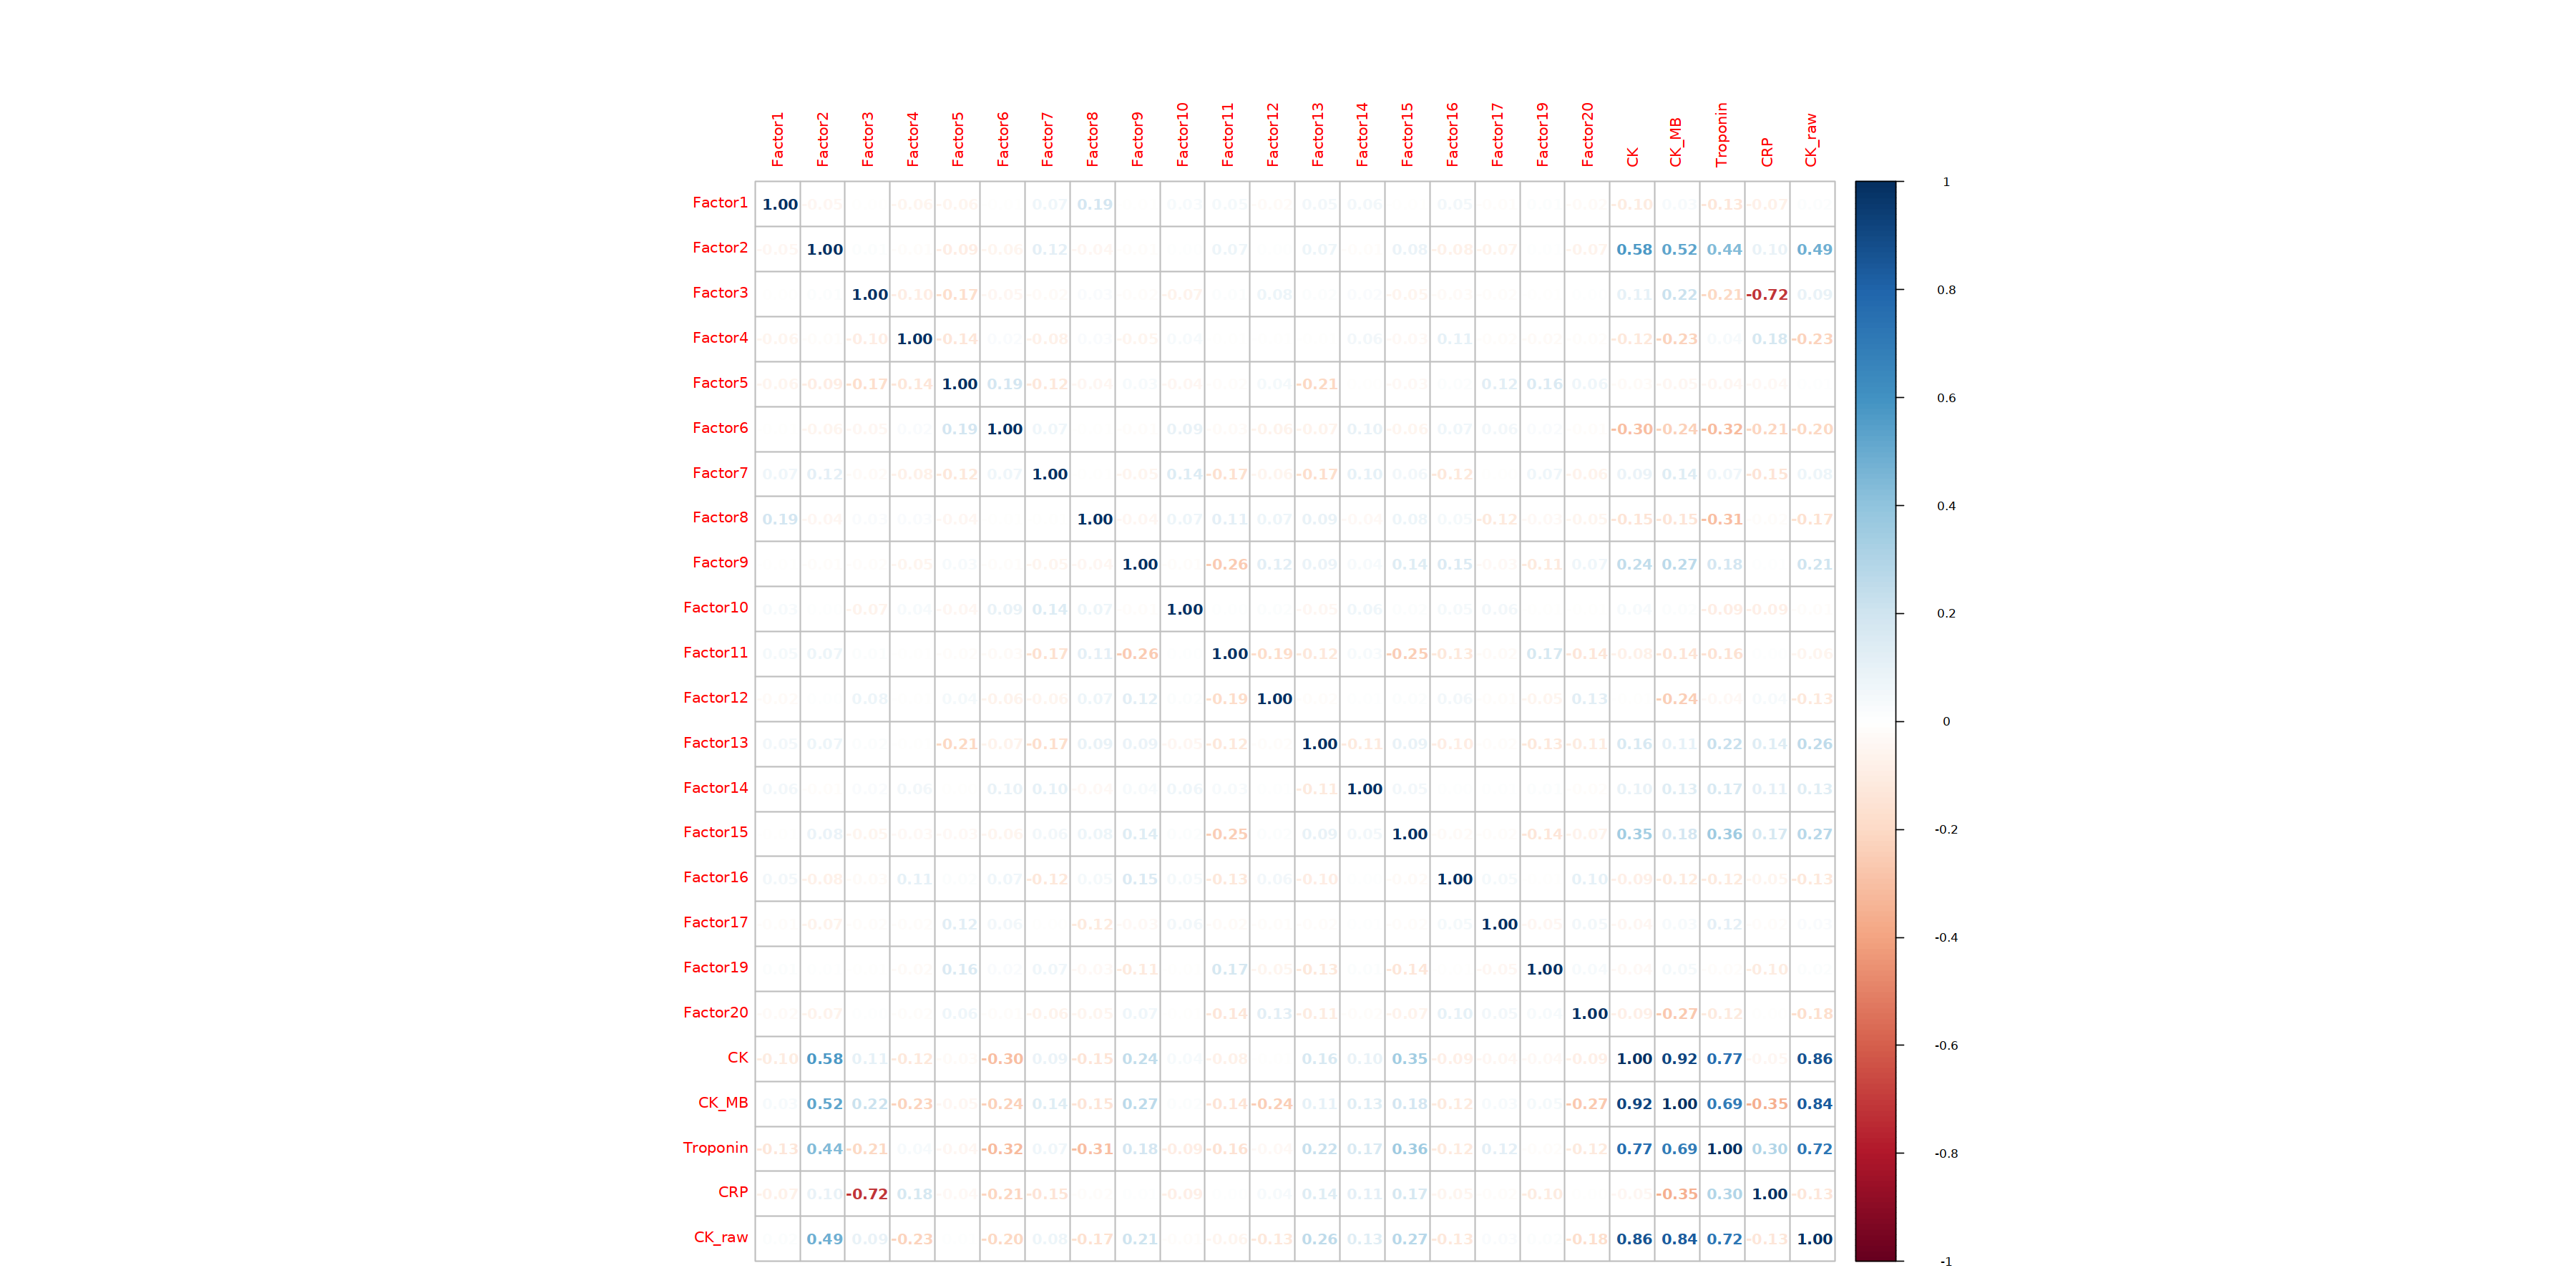

In [321]:
options(repr.plot.width=30, repr.plot.height=15)
corrplot(correlations, method = 'number')

# Plots

## Visualize Factor Patterns (Boxplot/ Lineplot)

### All factors pattern visualization

In [328]:
unique(merged_data_long$measurement)

[1] "TP0" "TP1" "TP2" "TP3" "TP4"

In [329]:
merged_data_long$measurement_concat = merged_data_long$measurement

merged_data_long$measurement_concat[merged_data_long$measurement == 'TP0'] = paste0(merged_data_long$measurement[merged_data_long$measurement == 'TP0'], '_',
            merged_data_long$class[merged_data_long$measurement == 'TP0'])

In [330]:
merged_data_long$measurement_concat = str_replace(merged_data_long$measurement_concat, 'TP0_no_ccs', 'No CCS')
merged_data_long$measurement_concat = str_replace(merged_data_long$measurement_concat, 'TP0_ccs', 'CCS')

In [331]:
unique(merged_data_long$measurement_concat)

[1] "No CCS" "CCS"    "TP1"    "TP2"    "TP3"    "TP4"

In [332]:
# Specific Text Descriptions:
xlabel = xlab('') 
ylabel = ylab('Factor Value')

In [333]:
figure_name = "SUPP2_Factor_Pattern_Time"

In [334]:
# Sizes of the plot
width_par = 8.07
height_par = 3.5

In [335]:
# grouped boxplot
#options(repr.plot.width=30, repr.plot.height=10)

vis_data = merged_data_long
g = ggplot(vis_data, aes(x=variable, y=value, fill = measurement_concat))  + 
    plot_config +
    xlabel + 
    ylabel +
    ccs_tp_fill +
    ggtitle('Pattern of factor values') + 
    theme(legend.position = "bottom", axis.text.x = element_text(angle = 90))+
    geom_boxplot(outlier.size = 0.05) 
#print(g)
pdf(paste0('figures/G_Azimuth/', figure_name, name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(g)
dev.off()



png 
  2

In [336]:
unique(vis_data$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

### Timeseries Visualization (good/ bad)

In [337]:
### Visualize with good/ poor outcome (poor = intermediate + bad)

In [338]:
# Specific Text Descriptions:
xlabel = xlab('Timepoint') 
ylabel = ylab('Median Value')

In [339]:
# Sizes of the plot
width_par = 2
height_par = 2

In [340]:
figure_name = "FIG3_E3_Factor_Patterns_Line_Plot_Classification"

In [341]:
for(i in c('Factor1',  'Factor3')){
    # Filter on factor
    vis_data = merged_data_long[merged_data_long$variable == i,]
    
    # Summarize data by relevant groups
    vis_data = vis_data %>% group_by(variable, measurement, delta_ef_value_class_summarized) %>% summarise(mean_value = mean(value) , median_value = median(value), sd_value = sd(value), quant_75 = quantile(value, probs = seq(0, 1, 0.25))['75%'], quant_25 = quantile(value, probs = seq(0, 1, 0.25))['25%'])
    
    # Remove ccs samples
    vis_data = vis_data[vis_data$measurement != 'TP0',]
    
    # Exclude NA
    vis_data = vis_data[!is.na(vis_data$delta_ef_value_class_summarized) ,]
    
    # Plot Median Plots
    

    pdf(paste0('figures/G_Azimuth/', figure_name,i,'_', name, train_opts$weight_views,'.pdf'), width =width_par, height = height_par)
    g = ggplot(data=vis_data, aes(x=measurement, y=median_value, group=delta_ef_value_class_summarized, color = delta_ef_value_class_summarized)) +
      geom_line(aes(color = delta_ef_value_class_summarized) , size=line_size)+
      geom_point(aes(color=delta_ef_value_class_summarized), size=point_size) +ggtitle(paste0(i)) + xlabel + ylabel +plot_config + geom_errorbar(aes(ymin=quant_25, ymax=quant_75 ), width=.1) + 
    good_bad_color +
    theme(legend.position = 'none')
    print(g)
    dev.off()

   } 
    

`summarise()` has grouped output by 'variable', 'measurement'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'variable', 'measurement'. You can override
using the `.groups` argument.


In [342]:
colnames(merged_data_long)

[1] "sample_id"                       "sample"                         
 [3] "measurement"                     "library"                        
 [5] "id.y"                            "name"                           
 [7] "read"                            "pattern"                        
 [9] "sequence"                        "feature_type"                   
[11] "X"                               "measurement_tp"                 
[13] "sex"                             "classification"                 
[15] "group"                           "delta_ef_value_group"           
[17] "delta_ef_value"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"                      "variable"                       
[25] "value"                           "class_measurement"              
[27] "measurement_concat"

### Timeseries Visualization (acs subtypes)

In [346]:
### Visualize with good/ poor outcome (poor = intermediate + bad)

In [347]:
# Specific Text Descriptions:
xlabel = xlab('Timepoint') 
ylabel = ylab('Median Value')

In [348]:
# Sizes of the plot
width_par = 2
height_par = 2

In [349]:
figure_name = "FIG3_E3_Factor_Patterns_Line_Plot_ACS_Subtypes"

In [350]:
colnames(merged_data_long)

[1] "sample_id"                       "sample"                         
 [3] "measurement"                     "library"                        
 [5] "id.y"                            "name"                           
 [7] "read"                            "pattern"                        
 [9] "sequence"                        "feature_type"                   
[11] "X"                               "measurement_tp"                 
[13] "sex"                             "classification"                 
[15] "group"                           "delta_ef_value_group"           
[17] "delta_ef_value"                  "delta_ef_value_class"           
[19] "class"                           "measurement2"                   
[21] "measurement_class"               "delta_ef_value_class_summarized"
[23] "tp_outcome"                      "variable"                       
[25] "value"                           "class_measurement"              
[27] "measurement_concat"

In [351]:
unique(merged_data_long$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

In [354]:
for(i in c( 'Factor2')){
    # Filter on factor
    vis_data = merged_data_long[merged_data_long$variable == i,]
    
    # Summarize data by relevant groups
    vis_data = vis_data %>% group_by(variable, measurement,classification) %>% summarise(mean_value = mean(value) , median_value = median(value), sd_value = sd(value), quant_75 = quantile(value, probs = seq(0, 1, 0.25))['75%'], quant_25 = quantile(value, probs = seq(0, 1, 0.25))['25%'])
    
    # Remove ccs samples
    vis_data = vis_data[vis_data$measurement != 'TP0',]
    
    # Exclude NA
    vis_data = vis_data[!is.na(vis_data$classification) ,]
    
    # Plot Median Plots
    
    pdf(paste0('figures/G_Azimuth/', figure_name,i,'_', name, train_opts$weight_views,'.pdf'), width =width_par, height = height_par)
    
    g = ggplot(data=vis_data, aes(x=measurement, y=median_value, group=classification, color = classification)) +
      geom_line(aes(color = classification) , size=line_size)+
      geom_point(aes(color=classification), size=point_size) +ggtitle(paste0(i)) + xlabel + ylabel +plot_config + geom_errorbar(aes(ymin=quant_25, ymax=quant_75 ), width=.1) + 
    acs_subtypes_color +
    theme(legend.position = 'none')
    print(g)
    dev.off()


   } 
    

`summarise()` has grouped output by 'variable', 'measurement'. You can override
using the `.groups` argument.


### Healthy vs. ccs vs. acs

In [355]:
unique(merged_data_long$group)

[1] "no_ccs" "ccs"    "acs"

In [356]:
merged_data_long$group = str_replace(merged_data_long$group, 'ccs', 'CCS')
merged_data_long$group = str_replace(merged_data_long$group, 'no_CCS', 'No CCS')
merged_data_long$group = str_replace(merged_data_long$group, 'acs', 'ACS')

In [357]:
# Specific Text Descriptions:
xlabel = xlab('Disease') 
ylabel = ylab('Factor Value')

In [358]:
figure_name = "FIG3_E3_Factor_Patterns_Healthy_CCS_Boxplot_all_samples"

In [359]:
# Sizes of the plot
width_par = 2
height_par = 3

In [360]:
# grouped boxplot
#options(repr.plot.width=30, repr.plot.height=10)

for(i in c('Factor1')){
    # Filter on factor
    vis_data = merged_data_long[merged_data_long$variable == i,]
    g = ggplot(vis_data, aes(x=reorder(group, -as.numeric(as.factor(group))), y=value, fill=group))  + 
        plot_config +
        xlabel + 
        ylabel +
        ccs_acs_color +
        ggtitle(i) + 
        geom_boxplot() +
        theme(legend.position = "none")
    #print(g)
    
    pdf(paste0('figures/G_Azimuth/', figure_name, name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
    print(g)
    dev.off()
    # print(g)
    }

In [361]:
unique(merged_data_long$classification)

[1] "vollstaendiger_ausschluss" "ccs"                      
[3] "koronarsklerose"           "acs_subacute"             
[5] "acs_w_infection"           "acs_w_o_infection"

### Time pattern (Factor2)

In [362]:
unique(merged_data_long$measurement)

[1] "TP0" "TP1" "TP2" "TP3" "TP4"

In [363]:
merged_data_long$measurement_plot = str_replace(merged_data_long$measurement, 'TP0', 'CCS')

In [364]:
# Specific Text Descriptions:
xlabel = xlab('Disease') 
ylabel = ylab('Factor Value')

In [365]:
figure_name = "FIG3_E3_Factor_Patterns_TP_all_samples"

In [366]:
# Sizes of the plot
width_par = 2
height_par = 2.8

In [367]:
# grouped boxplot
#options(repr.plot.width=30, repr.plot.height=10)

for(i in c('Factor2')){  # attention filtered on w_o_infection + ccs class
    # Filter on factor
    vis_data = merged_data_long[(merged_data_long$variable == i) & (merged_data_long$classification %in% c('ccs', 'acs_w_o_infection')),]
    g = ggplot(vis_data, aes(x=measurement_plot, y=value, fill = measurement_plot))  + 
        plot_config +
        xlabel + 
        ylabel +
        ccs_tp_fill +
        ggtitle(i) + 
        theme(legend.position = "none")+
        geom_boxplot() 
    #print(g)

    pdf(paste0('figures/G_Azimuth/', figure_name, name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
    print(g)
    dev.off()
    }

In [368]:
head(vis_data,2)

,sample_id,sample,measurement,library,id.y,name,read,pattern,sequence,feature_type,⋯,class,measurement2,measurement_class,delta_ef_value_class_summarized,tp_outcome,variable,value,class_measurement,measurement_concat,measurement_plot
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<chr>,<chr>
130,k10,K10,TP0,L11,HTO_B0256,Ch-CCS-10,R2,5PNNNNNNNNNN(BC),GGTTGCCAGATGTCA,Antibody Capture,⋯,ccs,TP0_ccs,TP0_ccs,NA,TP0_NA,Factor2,-1.038056,ccs,CCS,CCS
134,k14,K14,TP0,L11,HTO_B0257,Ch-CCS-14,R2,5PNNNNNNNNNN(BC),TGTCTTTCCTGCCAG,Antibody Capture,⋯,ccs,TP0_ccs,TP0_ccs,NA,TP0_NA,Factor2,-1.477676,ccs,CCS,CCS


In [369]:
nrow(vis_data)

[1] 81

In [370]:
unique(vis_data$classification)

[1] "ccs"               "acs_w_o_infection"

### Time and ccs acs pattern to add to variance decomp

In [371]:
unique(merged_data_long$class_measurement)

[1] "no_ccs" "ccs"    "TP1"    "TP2"    "TP3"    "TP4"

In [372]:
# Specific Text Descriptions:
xlabel = xlab('Disease') 
ylabel = ylab('Factor Value')

In [373]:
figure_name = "FIG1_E3_Factor_Patterns_TP_CCS"

In [374]:
# Sizes of the plot
width_par = 3
height_par = 3

In [375]:
ccs_tp_pattern = ggplot(merged_data_long, aes(x=variable, y=value, fill = class_measurement))  + 
        plot_config +
        xlabel + 
        ylabel +
        ccs_tp_fill +
        ggtitle(i) + 
        theme(legend.position = "none")+
        geom_boxplot() 

## Plot explained variance overview

In [376]:
#### Plot complete explained variance

In [377]:
# Specific Text Descriptions:
xlabel = xlab('Factor') 
ylabel = ylab('View')

In [378]:
figure_name = "FIG1_E3_Variance Decomposition"

In [379]:
# Sizes of the plot
width_par = 8.07
height_par = 3.12

In [380]:
var_decomp = ggplot() + 
    scale_fill_gradient(low="white", high="black") + 
    xlabel + 
    ylabel +
    plot_config + theme(axis.text.x = element_text(angle = 90), legend.position = 'right')+ 
    geom_tile(data = data, mapping = aes(Var1,  Var2, fill= value))

var_decomp2 = ggplot() + 
    scale_fill_gradient(low="white", high="black") + 
    xlabel + 
    ylabel +
    plot_config + theme(axis.text.x = element_text(angle = 90))+ 
    geom_tile(data = data[data$Var1 %in% c('Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5'),], mapping = aes(Var1,  Var2, fill= value))

In [381]:
pdf(paste0('figures/G_Azimuth/', figure_name, name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(var_decomp)
dev.off()

png 
  2

In [382]:
### Combine with total variance barplot per dimension

In [383]:
plot_complete = unique(data[,c('Var2', 'total_variance')])

In [384]:
head(data,2)

,Var2,Var1,value,total_variance
,<chr>,<fct>,<dbl>,<dbl>
1,Bcell,Factor1,5.811870,36.887
2,Bcell,Factor2,4.198111,36.887


In [385]:
# Specific Text Descriptions:
xlabel = xlab('View') 
ylabel = ylab('Explained Variance')

In [386]:
comp_variance = ggplot(plot_complete, aes(x=Var2, y = total_variance, fill = Var2)) + 
                geom_bar(stat="identity") + coord_flip() + 
                xlabel + 
                ylabel +
                plot_config + cell_type_colors

In [387]:
#comp_variance

In [388]:
### Plot with variance per factor

In [389]:
head(total_variance_factor,2)

,factor,mean_variance
,<chr>,<dbl>
Factor1,Factor1,5.491271
Factor2,Factor2,5.136342


In [390]:
# Specific Text Descriptions:
xlabel = xlab('Factor') 
ylabel = ylab('Explained Variance')

In [391]:
sort(unique(total_variance_factor$factor))

[1] "Factor1"  "Factor10" "Factor11" "Factor12" "Factor13" "Factor14"
 [7] "Factor15" "Factor16" "Factor17" "Factor18" "Factor19" "Factor2" 
[13] "Factor20" "Factor3"  "Factor4"  "Factor5"  "Factor6"  "Factor7" 
[19] "Factor8"  "Factor9"

In [392]:
comp_variance_factor = ggplot(total_variance_factor, aes(x=reorder(factor, -mean_variance), y = mean_variance, group = 1)) + 
                geom_line() + 
                xlabel + 
                ylabel +
                plot_config + theme(axis.text.x = element_text(angle = 90))

In [394]:
### Combine both visualization

In [395]:
figure_name = "FIG1_E3_Variance Decomposition_Combined"

In [396]:
# Sizes of the plot
width_par = 8.07
height_par = 2.8

In [397]:
legend = get_legend(var_decomp)

In [398]:
combination1 = ggarrange(var_decomp + theme(legend.position = 'none'),
                     comp_variance + theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank(), legend.position = 'none' ), 
                         align = 'h', nrow=1, widths = c(4,1))

In [399]:
combination1_ann = annotate_figure(
  combination1,
  right = legend
)

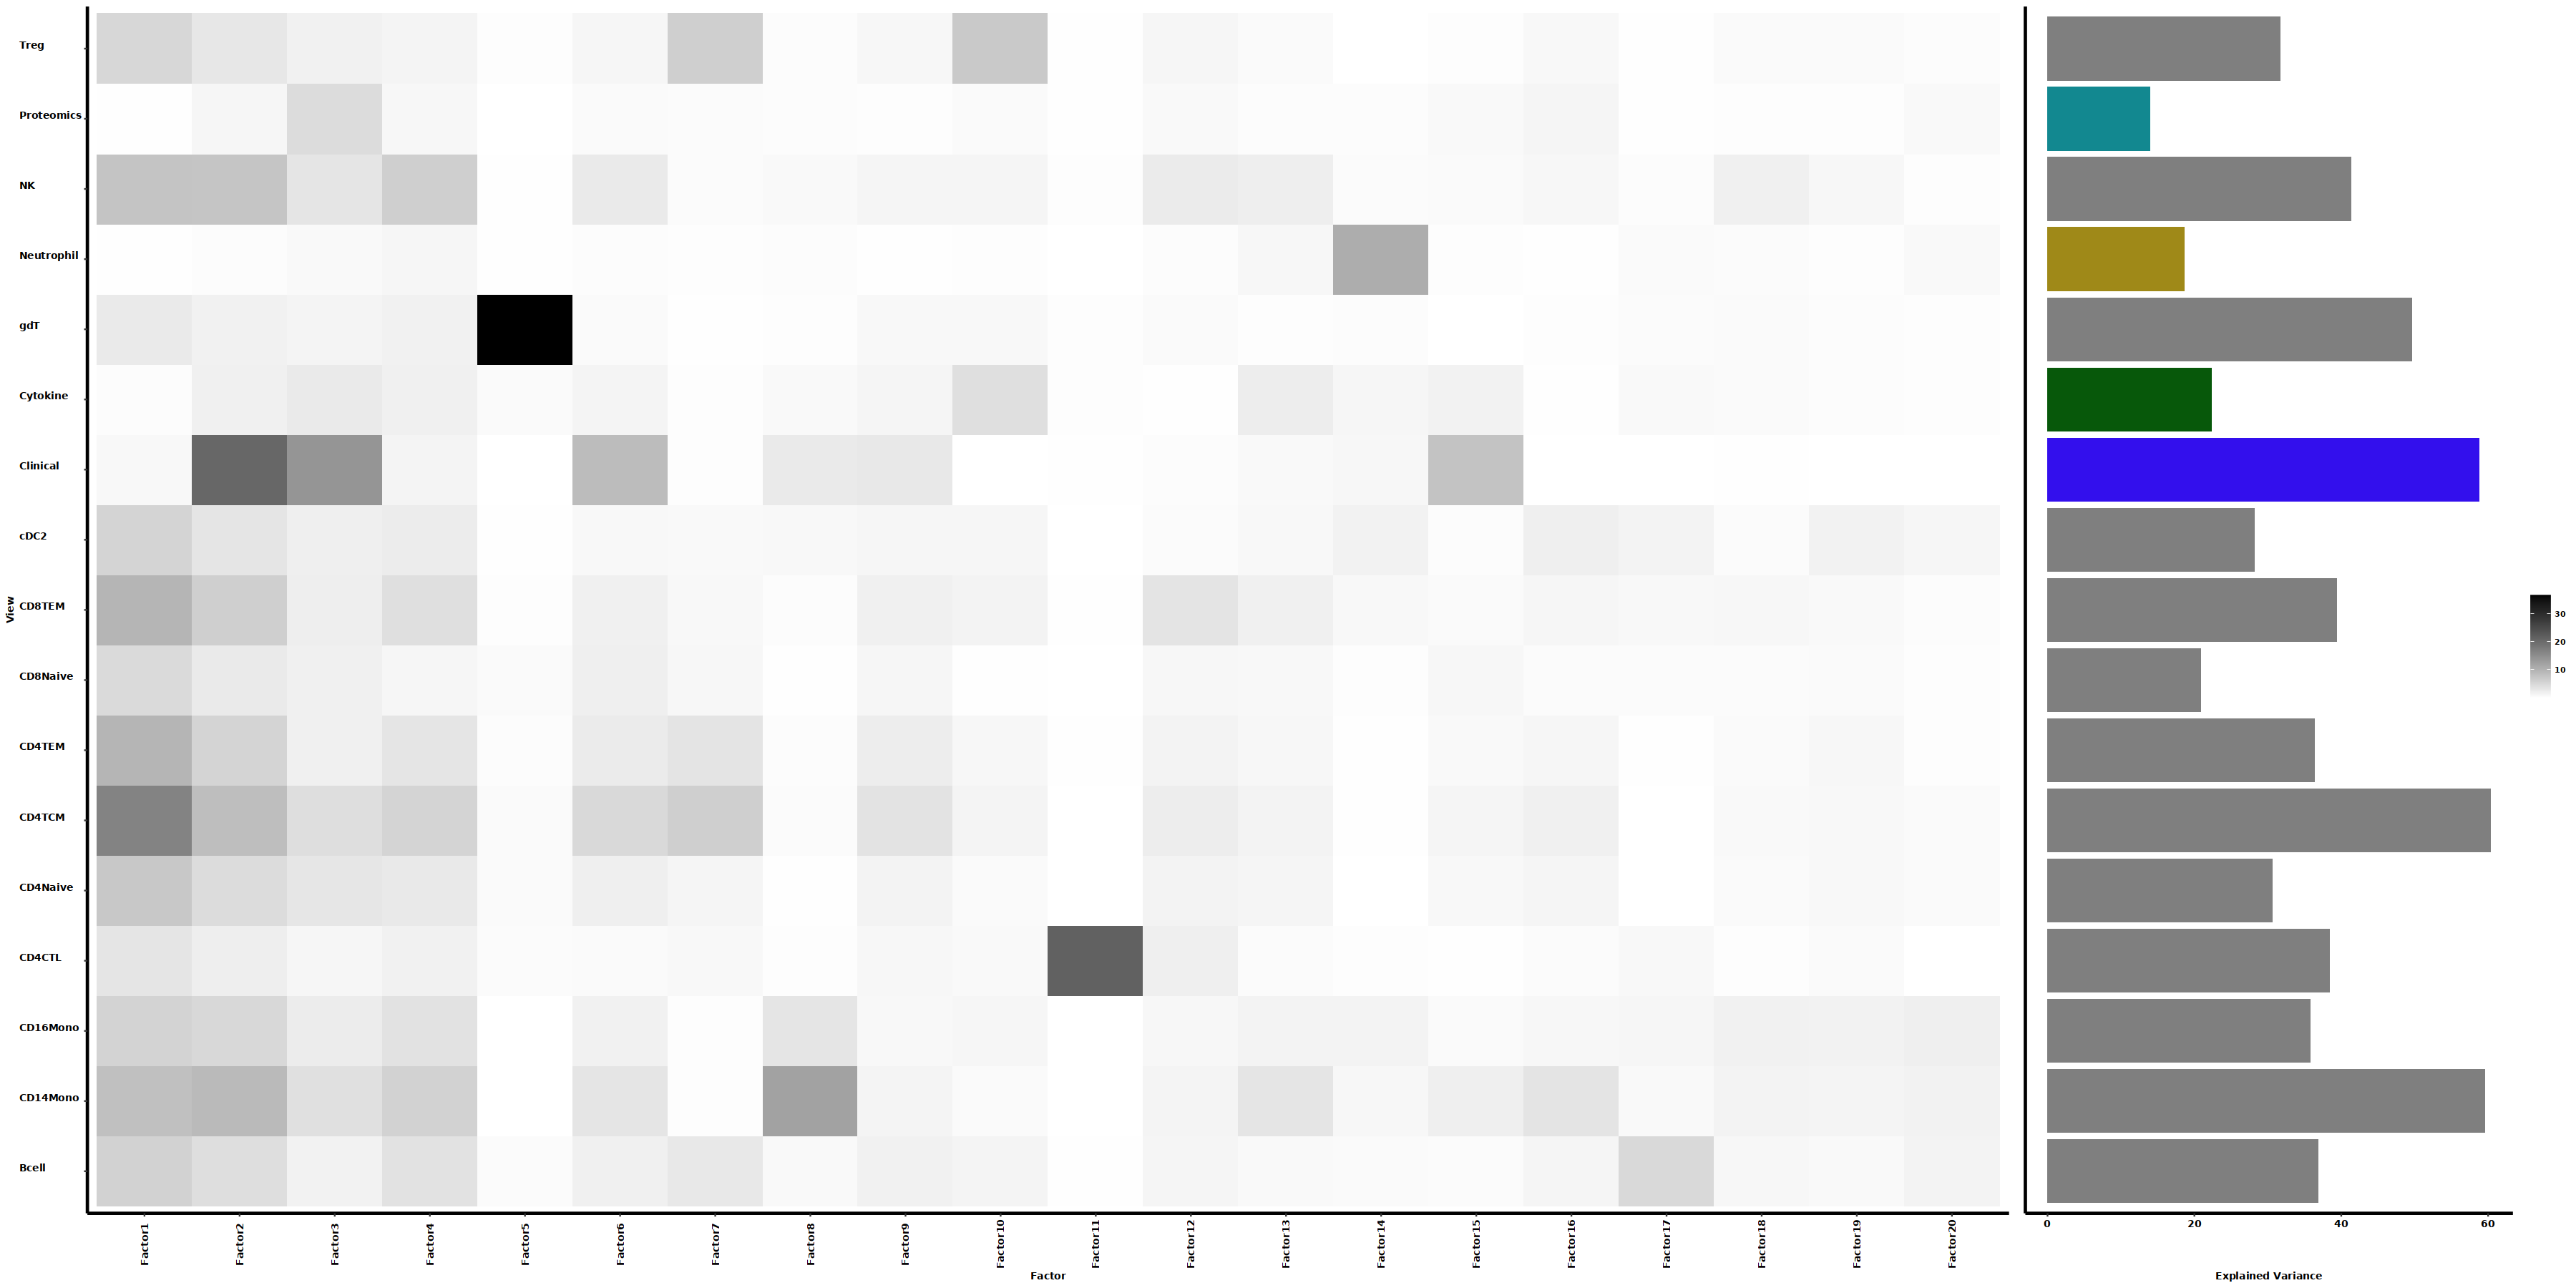

In [400]:
combination1_ann

In [401]:
pdf(paste0('figures/G_Azimuth/', figure_name, name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(combination1_ann)
dev.off()

png 
  2

In [402]:
### Combine with factor explained variance

In [403]:
figure_name = "FIG1_E3_Variance Decomposition_Combined_incl_factors"

In [404]:
# Sizes of the plot
width_par = 8.07
height_par = 3.12

In [405]:
empty_gg = ggplot()

In [406]:
combination1 = ggarrange(comp_variance_factor + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank()),empty_gg,
                var_decomp + theme(legend.position = 'none'),
                     comp_variance + theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank(), legend.position = 'none' ), 
                     
                         align = 'hv',ncol = 2,  nrow = 2, widths = c(4,1), heights = c(1,4))

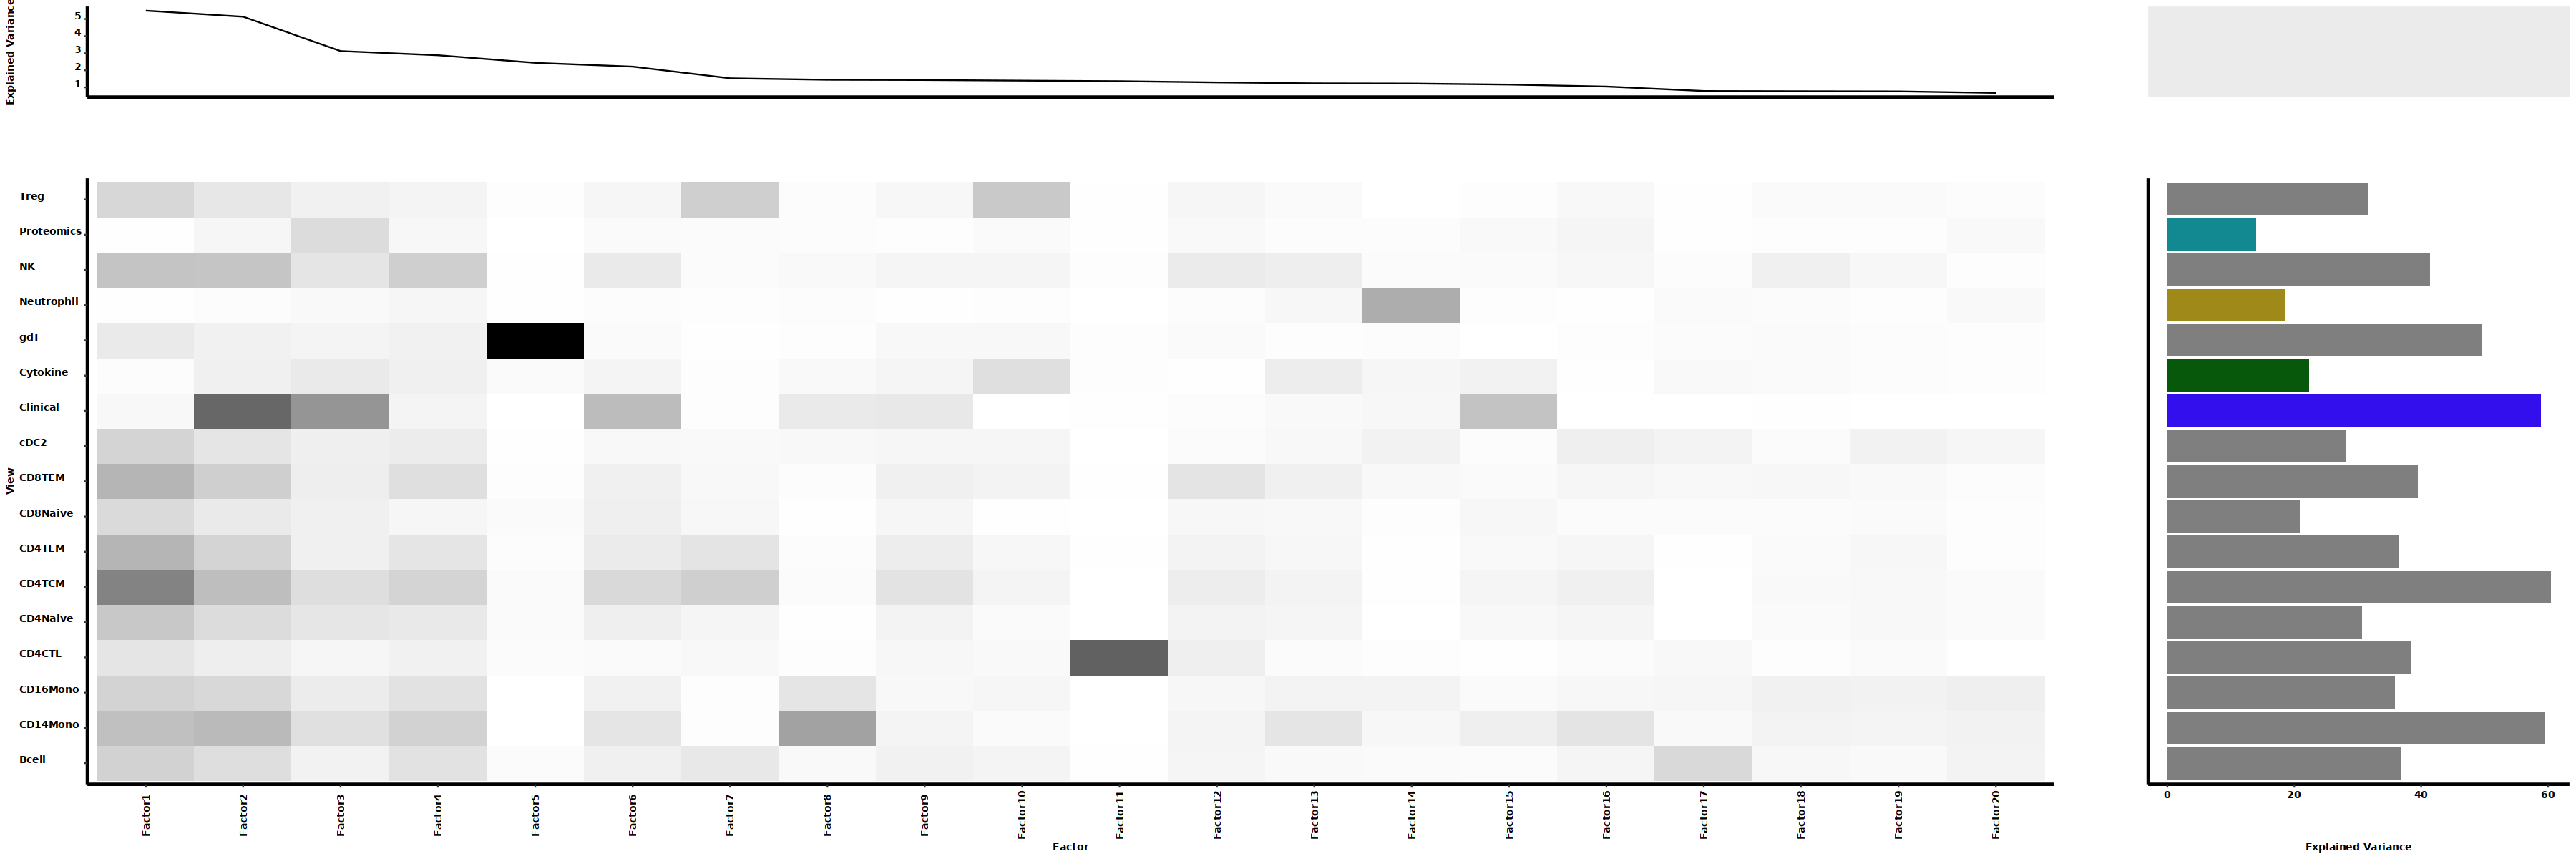

In [407]:
options(repr.plot.width=30, repr.plot.height=10)
print(combination1)

In [408]:
pdf(paste0('figures/G_Azimuth/', figure_name, name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
print(combination1)
dev.off()

png 
  2

## Explained variance and percentage of features per factor

### Explained Variance

In [409]:
source('MS4_Plot_Config.r')

In [410]:
#### Plot explained variance

In [411]:
# choose factor
factor_var = c('Factor1', 'Factor2', 'Factor3')

In [412]:
# Specific Text Descriptions:
xlabel = xlab('Variance') 
ylabel = ylab('View')

In [413]:
figure_name = "FIG2_E3_Variance Decomposition_Factor"

In [414]:
# Sizes of the plot
width_par = 4
height_par = 3.12

In [415]:
head(data,2)

,Var2,Var1,value,total_variance
,<chr>,<fct>,<dbl>,<dbl>
1,Bcell,Factor1,5.811870,36.887
2,Bcell,Factor2,4.198111,36.887


In [416]:
explained_variance_heatmap = list()

In [417]:
for(i in factor_var ){
    data_plot = data[data$Var1 == i,]
    data_plot$Var1 = 'Explained'
    
    explained_variance_heatmap[[i]] = ggplot() + scale_fill_gradient(low="white", high="black") + 
    ylabel + xlabel + 
    plot_config_heatmap  +
    geom_tile(data = data_plot, mapping = aes(Var1,  Var2, fill= value)
             )  +
    ggtitle(i)
    
    pdf(paste0('figures/G_Azimuth/', figure_name, '_', i, '_', name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
    print(explained_variance_heatmap[[i]])
    dev.off()
    }

### Feature Overview

In [422]:
# Specific Text Descriptions:
xlabel = xlab('View') 
ylabel = ylab('Percentage of total features')

In [423]:
figure_name = "FIG2_E3_Feature_Overview_Factor"

In [424]:
# Sizes of the plot
width_par = 4
height_par = 3.12

In [425]:
percentage_plot_1_perc = list()
percentage_plot_5_perc = list()

In [426]:
### Alternative 1 - percentage values
for(i in factor_var ){
    for(j in c('0.005')){
        
        percentage_plot_1_perc[[i]] = ggplot(data = geneset_oi_amounts[(geneset_oi_amounts$variable == i) & (geneset_oi_amounts$fraction == j),], aes(x = view, y = percentage*100, fill = view)) +
        xlabel + 
        ylabel + 
        plot_config + 
        geom_bar(stat="identity") + coord_flip()  + cell_type_colors + theme(legend.position = 'none') +
        ggtitle(paste0('Top ', 2*as.numeric(j) *100, '% of features')) +
        geom_hline(yintercept = 2*as.numeric(j)*100, 
                color = "black", size=1)
    }
    }

for(i in factor_var ){
    for(j in c('0.025')){
        
        percentage_plot_5_perc[[i]] = ggplot(data = geneset_oi_amounts[(geneset_oi_amounts$variable == i) & (geneset_oi_amounts$fraction == j),], aes(x = view, y = percentage*100, fill = view)) +
        xlabel + 
        ylabel + 
        plot_config + 
        geom_bar(stat="identity") + coord_flip() +  cell_type_colors + theme(legend.position = 'none')+ 
        ggtitle(paste0('Top ', 2*as.numeric(j) *100, '% of features')) +
        geom_hline(yintercept = 2*as.numeric(j)*100, 
                color = "black", size=1)
    }
    }

In [427]:
### Absolute amount features Plot

In [428]:
# Specific Text Descriptions:
xlabel = xlab('View') 
ylabel = ylab('Amount features')

In [429]:
absolute_plot_1_perc = list()

In [430]:
# one selected threshold + absolute amount
for(i in factor_var ){
    for(j in c('0.005')){
        
        absolute_plot_1_perc[[i]] = ggplot(data = geneset_oi_amounts[(geneset_oi_amounts$variable == i) & (geneset_oi_amounts$fraction == j),], aes(x = view, y = n, fill = view)) +
        xlabel + 
        ylabel + 
        plot_config + 
        geom_bar(stat="identity") + coord_flip()  +  cell_type_colors + theme(legend.position = 'none')+ 
        ggtitle(paste0('Top ', 2*as.numeric(j) *100, '% of features')) 
    }
    }


### Combined Plots

In [431]:
### Variant 1 diff visualizations

In [432]:
source('MS4_Plot_Config.r')

In [433]:
figure_name = paste0("FIG2_E3_View_Overview_Plot")

In [434]:
# Sizes of the plot
width_par = 6.07
height_par =2.8

In [435]:
options(repr.plot.width=width_par, repr.plot.height=height_par)

for( i in factor_var){
    legend = get_legend(explained_variance_heatmap[[i]])
    
    combined1 = ggarrange(explained_variance_heatmap[[i]] + theme(legend.position = 'none'),
                         absolute_plot_1_perc[[i]] + theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank() ), 
                         percentage_plot_1_perc[[i]] + theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank() ),  
                          nrow=1, widths = c(2.2,1,1))
    combined1 = annotate_figure(combined1, right = legend)
    
    pdf(paste0('figures/G_Azimuth/', figure_name, '_', i, '_', name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
    print( combined1)
    dev.off()
    }
    

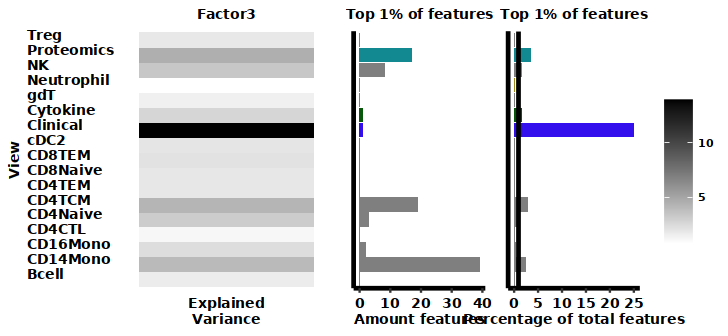

In [436]:
combined1

In [437]:
### Variant 2 diff thresholds

In [438]:
figure_name = paste0("FIG2_E3_View_Overview_PlotV2")

In [439]:
# Sizes of the plot
width_par = 8.07
height_par = 3.12

In [442]:
for( i in factor_var){
    legend = get_legend(explained_variance_heatmap[[i]])
    
    combined1 = ggarrange(explained_variance_heatmap[[i]] + theme(legend.position = 'none'),
                         percentage_plot_1_perc[[i]] + theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank() ), 
                         percentage_plot_5_perc[[i]] + theme(axis.text.y = element_blank(),axis.ticks.y = element_blank(),axis.title.y = element_blank() ),  
                          nrow=1, widths = c(2,1,1))
    combined1 = annotate_figure(combined1, right = legend)

    
    #pdf(paste0('figures/G_Azimuth/', figure_name, '_', i, '_', name, train_opts$weight_views, '.pdf'), width =width_par, height =height_par)
    #print( combined1)
    #dev.off()
    }
    

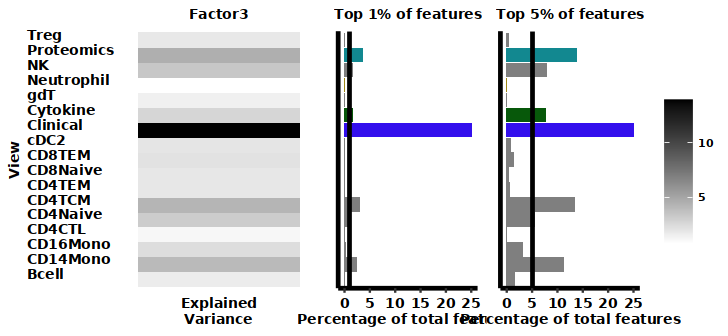

In [443]:
combined1